In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<br>
<br>
<br>
<br>

# **Treinamento do Modelo (Modelo Performático usando o Grid Search)**

Neste notebook vamos treinar o modelo usando outros algoritmos de machine learning, afim de melhorar a performance e desafiar o modelo de Regressão Logística. Aqui o processo será mais simples, pois não iremos categorizar as variáveis nem checar a ordenação, mas faremos uso de um tunning de hiperparâmetros (Grid Search) para encontrar as melhores opções.

<br>

## **Pacotes e Bibliotecas**

In [ ]:
# Instalação dos Pacotes.
!pip install colorama > /dev/null

In [ ]:
# Importando as bibliotecas Pandas e Numpy.
import pandas as pd
import numpy as np

# Importando a biblioteca Matplotlib para plotarmos gráficos que ajudarão no entendimento dos dados.
import matplotlib.pyplot as plt

# Importando as constantes definidas na biblioteca colorama que permitem alterar as cores e estilos de texto impresso no terminal.
from colorama import Fore, Style

# Importando a pickle para serialização.
import pickle

# Importando os algoritmos de Machine Learning que iremos utilizar nesse projeto.
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
import lightgbm as lgb
from xgboost import XGBClassifier

# Importando a classe GridSearchCV para nos ajudar a encontrar os melhores hiperparâmetros para um modelo.
from sklearn.model_selection import GridSearchCV

# Importando a itertools para trabalhar com iteradores e operações de iteração de forma simplificada e eficiente.
import itertools

# Importando a time para calcular tempo de processamento.
import time

# Importando as bibliotecas para avaliação dos modelos.
from sklearn.metrics import confusion_matrix, auc, roc_curve, precision_recall_curve, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score

<br>
<br>
<br>
<br>

## **Funções**

In [ ]:
# Função para checar quantidade de linhas e colunas dos conjuntos de treino e teste.
def info_dataframe(treino, teste):
    '''
    Esta função exibe informações sobre a quantidade de linhas e colunas dos conjuntos de treino e teste.

    Parâmetros:
    - treino: DataFrame do conjunto de treino.
    - teste: DataFrame do conjunto de teste.

    Retorna:
    Um print com as informações.
    '''

    # Criando uma borda destacada para o título do conjunto de treino.
    print(Fore.BLUE + '=' * 45)
    print('CONJUNTO DE TREINO'.center(45))
    print('')
    print('Quantidade de linhas:', treino.shape[0])
    print('Quantidade de colunas:', treino.shape[1])
    print('=' * 45 + Style.RESET_ALL)
    print('')

    # Criando uma borda destacada para o título do conjunto de teste.
    print(Fore.GREEN + '=' * 45)
    print('CONJUNTO DE TESTE'.center(45))
    print('')
    print('Quantidade de linhas:', teste.shape[0])
    print('Quantidade de colunas:', teste.shape[1])
    print('=' * 45 + Style.RESET_ALL)



# =================================================================================================================================================== #



# Função para calcular o KS.
def calcular_ks_statistic(y_true, y_score):
    '''
    Calcula o KS (Kolmogorov-Smirnov) para avaliação de um modelo de classificação.

    Parâmetros:
    - y_true: Valores verdadeiros.
    - y_score: Escores previstos.

    Retorna:
    - Valor do KS.
    '''

    df = pd.DataFrame({'score': y_score, 'target': y_true})
    df = df.sort_values(by='score', ascending=False)
    total_events = df.target.sum()
    total_non_events = len(df) - total_events
    df['cum_events'] = df.target.cumsum()
    df['cum_non_events'] = (df.target == 0).cumsum()
    df['cum_events_percent'] = df.cum_events / total_events
    df['cum_non_events_percent'] = df.cum_non_events / total_non_events
    ks_statistic = np.abs(df.cum_events_percent - df.cum_non_events_percent).max()
    return ks_statistic


# Função para calcular as métricas e plotar.
def avaliar_modelo(X_train, y_train, X_test, y_test, modelo, nm_modelo):
    '''
    Avalia um modelo de classificação e plota várias métricas de desempenho.

    Parâmetros:
    - X_train: Features do conjunto de treino.
    - y_train: Variável alvo do conjunto de treino.
    - X_test: Features do conjunto de teste.
    - y_test: Variável alvo do conjunto de teste.
    - modelo: Modelo treinado.
    - nm_modelo: Nome do modelo.

    Retorna:
    Uma série de gráficos com as principais métricas de desempenho para treino e teste.
    '''

    feature_names = list(X_train.columns)
    # Criação da figura e dos eixos.
    fig, axs = plt.subplots(5, 2, figsize=(15, 30))     # Ajustado para incluir novos gráficos.
    plt.tight_layout(pad=6.0)

    # Cor azul claro.
    cor = 'skyblue'

    # Taxa de Evento e Não Evento.
    event_rate = np.mean(y_train)
    non_event_rate = 1 - event_rate
    axs[0, 0].bar(['Evento', 'Não Evento'], [event_rate, non_event_rate], color=[cor, 'lightcoral'])
    axs[0, 0].set_title('Taxa de Evento e Não Evento')
    axs[0, 0].set_ylabel('Proporção')

    # Importância dos Atributos.
    importancias = None
    if hasattr(modelo, 'coef_'):      # hasattr = Tem atributo? Se tem coeficiênte ou não, se não tiver ele calcula a feature importance, sem tem coeficiênte, tem beta, ele calcula o peso do beta.
        importancias = np.abs(modelo.coef_[0])
    elif hasattr(modelo, 'feature_importances_'):
        importancias = modelo.feature_importances_

    if importancias is not None:
        importancias_df = pd.DataFrame({'feature': feature_names, 'importance': importancias})
        importancias_df = importancias_df.sort_values(by='importance', ascending=True)

        axs[0, 1].barh(importancias_df['feature'], importancias_df['importance'], color=cor)
        axs[0, 1].set_title('Importância das Variáveis - ' + nm_modelo)
        axs[0, 1].set_xlabel('Importância')

    else:
        axs[0, 1].axis('off')     # Desativa o subplot se não houver importâncias para mostrar.

    # Confusion Matrix - Treino.
    y_pred_train = modelo.predict(X_train)
    cm_train = confusion_matrix(y_train, y_pred_train)
    axs[1, 0].imshow(cm_train, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 0].set_title('Confusion Matrix - Treino - ' + nm_modelo)
    axs[1, 0].set_xticks([0, 1])
    axs[1, 0].set_yticks([0, 1])
    axs[1, 0].set_xticklabels(['0', '1'])
    axs[1, 0].set_yticklabels(['0', '1'])
    thresh = cm_train.max() / 2.
    for i, j in itertools.product(range(cm_train.shape[0]), range(cm_train.shape[1])):
        axs[1, 0].text(j, i, format(cm_train[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_train[i, j] > thresh else "black")

    # Confusion Matrix - Teste.
    y_pred_test = modelo.predict(X_test)
    cm_test = confusion_matrix(y_test, y_pred_test)
    axs[1, 1].imshow(cm_test, interpolation='nearest', cmap=plt.cm.Blues)
    axs[1, 1].set_title('Confusion Matrix - Teste - ' + nm_modelo)
    axs[1, 1].set_xticks([0, 1])
    axs[1, 1].set_yticks([0, 1])
    axs[1, 1].set_xticklabels(['0', '1'])
    axs[1, 1].set_yticklabels(['0', '1'])
    thresh = cm_test.max() / 2.
    for i, j in itertools.product(range(cm_test.shape[0]), range(cm_test.shape[1])):
        axs[1, 1].text(j, i, format(cm_test[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_test[i, j] > thresh else "black")

    # ROC Curve - Treino e Teste.
    y_score_train = modelo.predict_proba(X_train)[:, 1]
    fpr_train, tpr_train, _ = roc_curve(y_train, y_score_train)
    axs[2, 0].plot(fpr_train, tpr_train, color=cor, label='Treino')

    y_score_test = modelo.predict_proba(X_test)[:, 1]
    fpr_test, tpr_test, _ = roc_curve(y_test, y_score_test)
    axs[2, 0].plot(fpr_test, tpr_test, color='darkorange', label='Teste')

    axs[2, 0].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axs[2, 0].set_title('ROC Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 0].set_xlabel('False Positive Rate')
    axs[2, 0].set_ylabel('True Positive Rate')
    axs[2, 0].legend(loc="lower right")

    # Precision-Recall Curve - Treino e Teste.
    precision_train, recall_train, _ = precision_recall_curve(y_train, y_score_train)
    axs[2, 1].plot(recall_train, precision_train, color=cor, label='Treino')

    precision_test, recall_test, _ = precision_recall_curve(y_test, y_score_test)
    axs[2, 1].plot(recall_test, precision_test, color='darkorange', label='Teste')

    axs[2, 1].set_title('Precision-Recall Curve - Treino e Teste - ' + nm_modelo)
    axs[2, 1].set_xlabel('Recall')
    axs[2, 1].set_ylabel('Precision')
    axs[2, 1].legend(loc="upper right")

    # Gini - Treino e Teste.
    auc_train = roc_auc_score(y_train, y_score_train)
    gini_train = 2 * auc_train - 1
    auc_test = roc_auc_score(y_test, y_score_test)
    gini_test = 2 * auc_test - 1
    axs[3, 0].bar(['Treino', 'Teste'], [gini_train, gini_test], color=[cor, 'darkorange'])
    axs[3, 0].set_title('Gini - ' + nm_modelo)
    axs[3, 0].set_ylim(0, 1)
    axs[3, 0].text('Treino', gini_train + 0.01, f'{gini_train:.2f}', ha='center', va='bottom')
    axs[3, 0].text('Teste', gini_test + 0.01, f'{gini_test:.2f}', ha='center', va='bottom')

    # KS - Treino e Teste.
    ks_train = calcular_ks_statistic(y_train, y_score_train)
    ks_test = calcular_ks_statistic(y_test, y_score_test)
    axs[3, 1].bar(['Treino', 'Teste'], [ks_train, ks_test], color=[cor, 'darkorange'])
    axs[3, 1].set_title('KS - ' + nm_modelo)
    axs[3, 1].set_ylim(0, 1)
    axs[3, 1].text('Treino', ks_train + 0.01, f'{ks_train:.2f}', ha='center', va='bottom')
    axs[3, 1].text('Teste', ks_test + 0.01, f'{ks_test:.2f}', ha='center', va='bottom')

    # Decile Analysis - Teste.
    scores = modelo.predict_proba(X_test)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores.shape)     # Adiciona um pequeno ruído.
    scores += noise
    deciles = pd.qcut(scores, q=10, duplicates='drop')
    decile_analysis = y_test.groupby(deciles).mean()
    axs[4, 1].bar(range(1, len(decile_analysis) + 1), decile_analysis, color='darkorange')
    axs[4, 1].set_title('Ordenação do Score - Teste - ' + nm_modelo)
    axs[4, 1].set_xlabel('Faixas de Score')
    axs[4, 1].set_ylabel('Taxa de Evento')

    # Decile Analysis - Treino.
    scores_train = modelo.predict_proba(X_train)[:, 1]
    noise = np.random.uniform(0, 0.0001, size=scores_train.shape)     # Adiciona um pequeno ruído.
    scores_train += noise
    deciles_train = pd.qcut(scores_train, q=10, duplicates='drop')
    decile_analysis_train = y_train.groupby(deciles_train).mean()
    axs[4, 0].bar(range(1, len(decile_analysis_train) + 1), decile_analysis_train, color=cor)
    axs[4, 0].set_title('Ordenação do Score - Treino - ' + nm_modelo)
    axs[4, 0].set_xlabel('Faixas de Score')
    axs[4, 0].set_ylabel('Taxa de Evento')

    # Mostrar os gráficos.
    plt.show()



# =================================================================================================================================================== #



# Função para criar um DataFrame com as métricas de todos os modelos treinados.
def evaluate_models(X_train, y_train, X_test, y_test, models):
    '''
    Avalia múltiplos modelos de classificação e retorna um DataFrame com as métricas de desempenho de cada modelo, destacando as métricas mais altas.

    Parâmetros:
    - X_train: Features do conjunto de treino.
    - y_train: Variável alvo do conjunto de treino.
    - X_test: Features do conjunto de teste.
    - y_test: Variável alvo do conjunto de teste.
    - models: Dicionário contendo os modelos treinados.

    Retorna:
    DataFrame contendo as métricas de desempenho de todos os modelos.
    '''

    metrics = []
    for name, model in models.items():
        # Iniciando o cronômetro.
        import time
        start_time = time.time()

        # Prever os rótulos para os conjuntos de treino e teste.
        train_preds = model.predict(X_train)
        test_preds = model.predict(X_test)

        # Calcular as métricas.
        accuracy = accuracy_score(y_test, test_preds)
        precision = precision_score(y_test, test_preds)
        recall = recall_score(y_test, test_preds)
        f1 = f1_score(y_test, test_preds)
        auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])     # Supondo que é um problema de classificação binária.
        gini = 2*auc - 1
        ks = calcular_ks_statistic(y_test, model.predict_proba(X_test)[:, 1])

        # Calculando o tempo de treinamento.
        end_time = time.time()
        training_time = end_time - start_time

        # Adicionar ao array de métricas.
        metrics.append({
            'Model': name,
            'AUC-ROC': auc,
            'Accuracy': accuracy,
            'Precision': precision,
            'Recall': recall,
            'F1 Score': f1,
            'Gini': gini,
            'KS': ks,
            'Training_Time(s)': training_time
        })

    # Convertendo o array de métricas em um DataFrame.
    metrics_df = pd.DataFrame(metrics)

    # Ordenando o DataFrame pela metrica AUC-ROC.
    metrics_df_sorted = metrics_df.sort_values(by='AUC-ROC', ascending=False)

    # Função para destacar o maior valor em azul claro.
    def highlight_max(s):
        is_max = s == s.max()
        return ['background-color: lightblue' if v else '' for v in is_max]

    # Destacando o maior valor de cada métrica
    metrics_df_max = metrics_df_sorted.style.apply(highlight_max, subset=metrics_df.columns[1:-1])

    return metrics_df_max



# =================================================================================================================================================== #



# Função para cálculo das métricas de avaliação do modelo.
def calculate_metrics_01(nm_modelo, model, X_train, y_train, X_test, y_test):
    '''
    Esta função calcula métricas de avaliação para um modelo de classificação binária.

    Parâmetros:
    - model_name: Nome do modelo.
    - model: Modelo treinado.
    - X_train: Features do conjunto de treino.
    - y_train: Variável alvo do conjunto de treino.
    - X_test: Features do conjunto de teste.
    - y_test: Variável alvo do conjunto de teste.

    Retorna:
    Um DataFrame com as métricas calculadas para os conjuntos de treino e teste.
    '''

    # Fazendo predições.
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculando as métricas para o conjunto de treino.
    accuracy_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    auc_roc_train = roc_auc_score(y_train, model.predict_proba(X_train)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de treino.
    probabilities_train = model.predict_proba(X_train)[:, 1]
    df_train = pd.DataFrame({'true_labels': y_train, 'predicted_probs': probabilities_train})
    df_train = df_train.sort_values(by='predicted_probs', ascending=False)
    df_train['cumulative_true'] = df_train['true_labels'].cumsum() / df_train['true_labels'].sum()
    df_train['cumulative_false'] = (1 - df_train['true_labels']).cumsum() / (1 - df_train['true_labels']).sum()
    ks_statistic_train = max(abs(df_train['cumulative_true'] - df_train['cumulative_false']))
    gini_index_train = 2 * auc_roc_train - 1

    # Calculando as métricas para o conjunto de teste.
    accuracy_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    auc_roc_test = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

    # Calculando o Índice Gini e Estatística KS para o conjunto de teste.
    probabilities_test = model.predict_proba(X_test)[:, 1]
    df_test = pd.DataFrame({'true_labels': y_test, 'predicted_probs': probabilities_test})
    df_test = df_test.sort_values(by='predicted_probs', ascending=False)
    df_test['cumulative_true'] = df_test['true_labels'].cumsum() / df_test['true_labels'].sum()
    df_test['cumulative_false'] = (1 - df_test['true_labels']).cumsum() / (1 - df_test['true_labels']).sum()
    ks_statistic_test = max(abs(df_test['cumulative_true'] - df_test['cumulative_false']))
    gini_index_test = 2 * auc_roc_test - 1

    # Criando o DataFrame com as métricas calculadas.
    metrics_df = pd.DataFrame({
        'Algoritmo': [nm_modelo, nm_modelo],
        'Conjunto': ['Treino', 'Teste'],
        'Acuracia': [accuracy_train, accuracy_test],
        'Precision': [precision_train, precision_test],
        'Recall': [recall_train, recall_test],
        'AUC_ROC': [auc_roc_train, auc_roc_test],
        'GINI': [gini_index_train, gini_index_test],
        'KS': [ks_statistic_train, ks_statistic_test]
    })

    return metrics_df



# =================================================================================================================================================== #



# Função para criação dos gráficos com as faixas de score e apetite de risco da base de treino.
def carteira_treino_rl(model, name_model, risk, X_train, y_train, prob_train):
  '''
  Esta função:
  - Faz as predições de probabilidade de evento e não-evento da base passada como parâmetro.
  - Separa os scores em 10 faixas.
  - Calcula a volumetria e a taxa de evento de cada faixa.
  - Gera uma linha horizontal que representa o apetite de risco assumido.
  - Analisa cada faixa e aplica cores diferentes nas barras de acordo com a taxa de evento da faixa e o apetite de risco assumido.
  - Calcula o percentual do público aprovado e não aprovado, de acordo com o apetitie de risco.

  Parâmetros:
  - model: Modelo que fará as predições.
  - name_model: Nome do modelo. Ex: 'Random Forest'.
  - risk: Risco, em decimais, possível de ser assumido (geralmente igual a inadimplência da carteira).
  - X_train: Base usada no treinamento do modelo.
  - y_train: Target usada no treinamento do modelo.
  - prob_train: Taxa de probabilidade da base de treino.

  Retorna:
  Faixas de limites superiores e inferiores de cada faixa de score. Esta faixa poderá ser passada como parâmetro na função 'carteira_teste' para que os limites das faixas sejam mantidos.
  '''

  # Configura o plot.
  fig, ax = plt.subplots(figsize=(12, 6))


  # Função para preencher as barras com cores diferentes.
  def fill_bars(ax, values, color_above, color_below, threshold=None):
    for val, bar in zip(values, ax.patches):
      if threshold is not None:
        if val >= threshold:
          bar.set_color(color_above)
        else:
          bar.set_color(color_below)
      else:
        bar.set_color(color_above if val >= risk else color_below)


  # Função para adicionar a linha horizontal de risco no eixo secundário.
  def add_risk_line(ax, risk_value, color='black'):

    # Adiciona a linha horizontal que representa o apetite de risco assumido.
    ax.axhline(y=risk_value, color=color, linestyle='--')

    # Adicionar texto acima da linha.
    texto_acima_linha = f'Risco: {100*risk_value:.1f}%'
    ax.text(0.5, risk_value+ 0.0025, texto_acima_linha)


  # Função para calcular as faixas (bins) e plotar o gráfico de barras dos dados de treino.
  def plot_bar_chart(ax, probabilidades, y_real, title, color_default, color_above, color_below, risk_value=None):
    df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_real})
    df = df.sort_values(by='Probabilidades', ascending=False)
    df['Deciles'] = pd.qcut(df['Probabilidades'], q=10, labels=False, duplicates='drop')

    # Volumetria das faixas.
    df_vol = df.groupby('Deciles')['Deciles'].count().values

    # Extraindo o limite superior de score das faixas.
    faixas=[]
    for i in range(0,10):
      if i != 9:
        faixas.append(round(1000*df.loc[df['Deciles']==i ,'Probabilidades'].max()  , 0))
      else:
        faixas.append( 1000 )

    # Criando uma lista com os rótulos de cada bin.
    rotulos=[]
    for i in range(0, len(faixas)):
      if i == 0:
        rotulos.append(f'000 - {faixas[i]:.0f}')
      else:
        rotulos.append(f'{faixas[i-1]:.0f} - {faixas[i]:.0f}')

    # Agrupando os deciles e cálculando a média da propabilidade de evento em cada um.
    decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

    # Criação do eixo secundário.
    ax2 = ax.twinx()

    # Plota as linhas para a taxa de evento em cada bin no eixo secundário.
    ax2.plot(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='magenta', marker='o', label='Taxa de Evento')
    ax2.set_ylabel('Taxa de Evento')

    # Adiciona rótulos para a linha de taxa de evento.
    for i, (x, y) in enumerate(zip(decile_analysis['Deciles'], decile_analysis['Resposta Real'])):
      ax2.annotate(f'{y:.2f}', xy=(x, y), xytext=(10, 10), textcoords='offset points', ha='center', va='center', color='magenta')

    # Desligando o grid do gráfico secondário.
    ax2.grid(False)

    # Plota as barras de volumetria com cores diferentes se a taxa de evento for superior ao risk_value.
    for i, color in enumerate(['mistyrose', 'lightgreen'] * 5):
      ax.bar(i, df_vol[i], color=color if decile_analysis.loc[i, 'Resposta Real'] >= risk_value else color_default)

    # Configurações do gráfico.
    ax.set_title(title, pad=10)
    ax.set_xlabel('Faixas de Score')
    ax.set_ylabel('Volumetria da faixa')
    ax.set_xticks(range(len(rotulos)))
    ax.set_ylim(0, 1.2 * np.max(df_vol)) #Valor maximo do eixo y igual a 20% do maior valor de volumetria.
    ax.grid(False)

    # Configuração dos rótulos do eixo X para o gráfico.
    ax.set_xticklabels(rotulos, rotation=0)

    # Adicionando linha horizontal que representa o risco no eixo secundário.
    add_risk_line(ax2, risk_value)
    fill_bars(ax, decile_analysis['Resposta Real'], color_above, color_below, risk_value)

    # Lendo os deciles que estão abaixo da linha de risco.
    faixas_aprovadas = decile_analysis.loc[decile_analysis['Resposta Real']<=risk_value , 'Deciles']
    faixas_reprovadas = decile_analysis.loc[decile_analysis['Resposta Real']>risk_value , 'Deciles']

    # Convertendo em lista as faixas aprovadas / reprovadas.
    faixas_aprovadas = faixas_aprovadas.to_list()
    faixas_reprovadas = faixas_reprovadas.to_list()

    # Calculando a quantidade de pessoas aprovadas / reprovadas.
    qtd_aprovadas = df.loc[df['Deciles'].isin(faixas_aprovadas) ,  'Deciles'].count()
    qtd_reprovadas = df.loc[df['Deciles'].isin(faixas_reprovadas), 'Deciles'].count()

    # Calculando o percentual de pessoas aprovadas / reprovadas.
    perc_aprovadas = 100*round(qtd_aprovadas / df.shape[0]   , 2 )
    perc_reprovadas = 100*round(qtd_reprovadas / df.shape[0] , 2 )

    return perc_aprovadas , perc_reprovadas , color_above, color_below , faixas , df


  # -------------------------------------------------------------
  # Chamando a função de plot para dados de treino.
  # -------------------------------------------------------------

  # Previsão das probabilidades no conjunto de treino.
  # Probabilidade de NÃO-EVENTO (para inverter o gráfico).
  probabilidades_train = prob_train

  # Adiciona um pequeno ruído às probabilidades.
  noise_train = np.random.uniform(0, 0.0001, size=probabilidades_train.shape)
  probabilidades_train += noise_train

  # Plota o gráfico de barras para o conjunto de treino.
  perc_apr , perc_rep , color_above, color_below , faixas , df= plot_bar_chart(ax, probabilidades_train, y_train, 'Faixas de score, volumetrias e taxa de evento - base de treino ' + name_model,
                    'steelblue' , 'mistyrose', 'lightgreen', risk)

  # Criar entradas para a legenda com base nas cores.
  legend_labels = [f'Aprovados:   {perc_apr}% da base', f'Reprovados: {perc_rep}% da base']
  legend_colors = [color_below, color_above]

  # Adicionar manualmente entradas para cada cor na legenda.
  for label, color in zip(legend_labels, legend_colors):
    ax.bar(0, 0, color=color, label=label, linewidth=0)

  # Inserir legenda
  ax.legend( loc='upper left', bbox_to_anchor=(1.1, 1))

  plt.show()

  return faixas



# Função para criação dos gráficos com as faixas de score e apetite de risco da base de teste.
def carteira_teste_rl(faixas, model, name_model, risk, X_test, y_test , prob_test):
  '''
  Esta função:
  - Faz as predições de probabilidade de evento e não-evento da base passada como parâmetro.
  - Separa os scores em 10 faixas.
  - Calcula a volumetria e a taxa de evento de cada faixa.
  - Gera uma linha horizontal que representa o apetite de risco assumido.
  - Analisa cada faixa e aplica cores diferentes nas barras de acordo com a taxa de evento da faixa e o apetite de risco assumido.
  - Calcula o percentual do público aprovado e não aprovado, de acordo com o apetitie de risco.

  Parâmetros:
  - model: Modelo que fará as predições.
  - name_model: Nome do modelo. Ex: 'Random Forest'.
  - risk: Risco, em decimais, possível de ser assumido (geralmente igual a inadimplência da carteira).
  - X_test: Base usada no teste do modelo.
  - y_test: Target usada no teste do modelo.
  - prob_test: Taxa de probabilidade da base de teste.

  Retorna:
  Faixas de limites superiores e inferiores de cada faixa de score. Esta faixa poderá ser passada como parâmetro na função 'carteira_teste' para que os limites das faixas sejam mantidos.
  '''

  # Configura o plot.
  fig, ax = plt.subplots(figsize=(12, 6))

  # Função para preencher as barras com cores diferentes.
  def fill_bars(ax, values, color_above, color_below, threshold=None):
    for val, bar in zip(values, ax.patches):
      if threshold is not None:
        if val >= threshold:
          bar.set_color(color_above)
        else:
          bar.set_color(color_below)
      else:
        bar.set_color(color_above if val >= risk else color_below)


  # Função para adicionar a linha horizontal de risco no eixo secundário.
  def add_risk_line(ax, risk_value, color='black'):

    # Adiciona a linha horizontal que representa o risco.
    ax.axhline(y=risk_value, color=color, linestyle='--')

    # Adicionar texto acima da linha
    texto_acima_linha = f'Risco: {100*risk_value:.1f}%'
    ax.text(0.5, risk_value+ 0.0025, texto_acima_linha)


  # Função para aplicar as faixas (bins) e plotar o gráfico de barras dos dados de teste.
  def apply_deciles_plot_bar_chart(faixas, ax, probabilidades, y_real, title, color_default, color_above, color_below, risk_value=None):
    df = pd.DataFrame({'Probabilidades': probabilidades, 'Resposta Real': y_real})
    df = df.sort_values(by='Probabilidades', ascending=False)

    # Ajustando os valores dos limites superiores e inferiores das faixas que anteriormente tinham sido multiplicados por mil.
    faixas = np.array(faixas)
    faixas=np.divide(faixas, 1000)
    faixas = faixas.tolist()

    # Adcionando o valor 0 no primeiro indice da lista de faixas.
    faixas.insert(0, 0)

    # Aplica as faixas fornecidas
    df['Deciles'] = pd.cut(df['Probabilidades'], bins=faixas, labels=False, include_lowest=True)

    # Volumetria das faixas
    df_vol = df.groupby('Deciles')['Deciles'].count().values


    # Removendo novamente o valor Zero (que está no ídice Zero) para a lista ter a mesma configuração do código anterior antes da extração dos rótulos.
    faixas.pop(0)

    # Criando uma lista com os rótulos de cada bin, multiplicando por mil.
    rotulos=[]
    for i in range(0, len(faixas)):
      if i == 0:
        rotulos.append(f'000 - {1000*faixas[i]:.0f}')
      else:
        rotulos.append(f'{1000*faixas[i-1]:.0f} - {1000*faixas[i]:.0f}')


    # Calculo da média de probabilidade de taxa de evento em cada bin.
    decile_analysis = df.groupby('Deciles')['Resposta Real'].mean().reset_index()

    # Criação do eixo secundário.
    ax2 = ax.twinx()

    # Plota as linhas para a taxa de evento em cada bin no eixo secundário.
    ax2.plot(decile_analysis['Deciles'], decile_analysis['Resposta Real'], color='magenta', marker='o', label='Taxa de Evento')
    ax2.set_ylabel('Taxa de Evento')

    # Adiciona rótulos para a linha de taxa de evento.
    for i, (x, y) in enumerate(zip(decile_analysis['Deciles'], decile_analysis['Resposta Real'])):
      ax2.annotate(f'{y:.2f}', xy=(x, y), xytext=(10, 10), textcoords='offset points', ha='center', va='center', color='magenta')

    # Desligando o grid do gráfico secundário.
    ax2.grid(False)


    # Plota as barras de volumetria com cores diferentes se a taxa de evento for superior ao risk_value.
    for i, color in enumerate(['mistyrose', 'lightgreen'] * 5):
      ax.bar(i, df_vol[i], color=color if decile_analysis.loc[i, 'Resposta Real'] >= risk_value else color_default)

    # Configurações do gráfico.
    ax.set_title(title, pad=10)
    ax.set_xlabel('Faixas de Score')
    ax.set_ylabel('Volumetria da faixa')
    ax.set_xticks(range(len(rotulos)))
    ax.set_ylim(0, 1.2 * np.max(df_vol))  # Valor maximo do eixo y igual a 20% do maior valor de volumetria.
    ax.grid(False)


    # Configuração dos rótulos do eixo X para o gráfico.
    ax.set_xticklabels(rotulos, rotation=0)

    # Adicionando a linha horizontal que representa o risco no eixo secundário.
    add_risk_line(ax2, risk_value)
    fill_bars(ax, decile_analysis['Resposta Real'], color_above, color_below, risk_value)

    # Lendo os deciles que estão abaixo da linha de risco
    faixas_aprovadas = decile_analysis.loc[decile_analysis['Resposta Real']<=risk_value , 'Deciles']
    faixas_reprovadas = decile_analysis.loc[decile_analysis['Resposta Real']>risk_value , 'Deciles']

    # Convertendo em lista as faixas aprovadas / reprovadas.
    faixas_aprovadas = faixas_aprovadas.to_list()
    faixas_reprovadas = faixas_reprovadas.to_list()

    # Calculando a quantidade de pessoas aprovadas / reprovadas.
    qtd_aprovadas = df.loc[df['Deciles'].isin(faixas_aprovadas) ,  'Deciles'].count()
    qtd_reprovadas = df.loc[df['Deciles'].isin(faixas_reprovadas), 'Deciles'].count()

    # Calculando o percentual de pessoas aprovadas / reprovadas.
    perc_aprovadas = 100*round(qtd_aprovadas / df.shape[0]   , 1 )
    perc_reprovadas = 100*round(qtd_reprovadas / df.shape[0] , 1 )

    return perc_aprovadas , perc_reprovadas , color_above, color_below


  # -----------------------------------------------------------------------
  # Chamando a função de plot para dados de teste com os bins fixados.
  # -----------------------------------------------------------------------

  # Previsão das probabilidades no conjunto de teste.
  # Probabilidade de NÃO-EVENTO (para inverter o gráfico).
  probabilidades_test = prob_test

  # Adiciona um pequeno ruído às probabilidades.
  noise_test = np.random.uniform(0, 0.0001, size=probabilidades_test.shape)
  probabilidades_test += noise_test

  # Plota o gráfico de barras para o conjunto de teste.
  perc_apr , perc_rep , color_above, color_below = apply_deciles_plot_bar_chart (faixas, ax, probabilidades_test, y_test, 'Faixas de score, volumetrias e taxa de evento - base de teste ' + name_model,
                  'steelblue' , 'mistyrose', 'lightgreen', risk)

  # Criar entradas para a legenda com base nas cores.
  legend_labels = [f'Aprovados:   {perc_apr}% da base', f'Reprovados: {perc_rep}% da base']
  legend_colors = [color_below, color_above]

  # Adicionar manualmente entradas para cada cor na legenda.
  for label, color in zip(legend_labels, legend_colors):
    ax.bar(0, 0, color=color, label=label, linewidth=0)

  # Inserir legenda.
  ax.legend( loc='upper left', bbox_to_anchor=(1.1, 1))

  plt.show()

  return faixas

<br>
<br>
<br>
<br>

## **Diretórios**

In [ ]:
# Salvando o caminho do diretório principal.
dir = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech'

# Salvando o caminho do diretório dos arquivos pickle.
dir_pkl = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech/modelo_desafiante/artefatos'

# Salvando o caminho do diretório das ABTs.
dir_abt = '/content/drive/MyDrive/Projetos_Big_Data_Analytics/Ciencia_de_Dados/Etapa_Modelagem_Credito/pod-academy-analise-de-credito-para-fintech/modelo_desafiante/abt'

<br>
<br>
<br>
<br>

## **Leitura das ABTs**

In [ ]:
# Lendo as bases de dados.
abt_train_01 = pd.read_csv(dir_abt + '/abt_train_01.csv')
abt_test_01 = pd.read_csv(dir_abt + '/abt_test_01.csv')

info_dataframe(abt_train_01, abt_test_01)

              CONJUNTO DE TREINO             

Quantidade de linhas: 172205
Quantidade de colunas: 13

              CONJUNTO DE TESTE              

Quantidade de linhas: 43052
Quantidade de colunas: 13


In [ ]:
# Definindo a opção para não truncar colunas.
pd.set_option('display.max_columns', None)

abt_train_01.head(10)

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,OCCUPATION_TYPE,ORGANIZATION_TYPE,TARGET,SK_ID_CURR
0,-0.793053,1.836741e+00,0.061971,-5.029701e-03,1.010821,0.033633,0.475008,-0.368631,-0.164555,0.063887,0.096493,0,281575
1,-1.156049,-7.967728e-16,0.965016,-8.247463e-01,-2.269965,-0.096974,-0.879459,-0.297123,-0.264697,0.105932,0.092509,0,253241
2,1.038227,-1.545829e+00,0.877222,-2.071589e+00,1.010821,2.332020,-0.455511,0.000000,0.000000,0.063887,0.092509,0,257591
3,-1.335136,-7.967728e-16,-1.374206,-1.274619e-15,1.010821,0.138083,-1.339922,0.000000,-0.292035,0.065004,0.053759,0,440634
4,0.634133,-7.967728e-16,-1.849493,-1.188729e-01,-0.280528,-1.084114,0.732162,0.000000,-0.071142,0.115646,0.092509,0,101232
5,-0.763894,1.243946e+00,0.722401,1.494769e+00,-1.199679,-1.084218,0.822831,0.318456,-0.171700,0.102986,0.074571,0,378713
6,-0.680320,1.666766e+00,0.650742,-2.930107e+00,0.263306,0.618315,-0.670889,0.000000,0.000000,0.065004,0.058163,0,253842
7,-1.521570,-7.967728e-16,-1.449090,1.154902e+00,-0.672499,-0.397278,-1.319499,0.000000,-0.152185,0.065004,0.053759,0,223682
8,1.036620,-2.144859e+00,-2.591566,-7.472015e-01,1.010821,-0.279021,-1.353538,-0.370480,-0.166483,0.102986,0.092509,0,421310
9,-2.028754,-7.967728e-16,0.857958,-1.274619e-15,0.093343,0.798892,-0.648918,-0.165438,0.047273,0.065004,0.053759,0,290144


In [ ]:
abt_test_01.head(10)

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,OCCUPATION_TYPE,ORGANIZATION_TYPE,TARGET,SK_ID_CURR
0,1.482272,-2.046844e+00,0.630504,2.524676e-01,1.010821,-0.164572,-1.248325,-0.163901,0.048876,0.105932,0.092509,0,243431
1,-0.945047,2.160400e+00,-0.067148,-7.276433e-01,-0.381871,0.031893,1.058633,0.000000,0.000000,0.105932,0.092509,0,127962
2,1.008839,-7.967728e-16,-1.234555,-1.210403e+00,1.010821,-0.225103,-0.362057,0.000000,-0.064871,0.105932,0.115911,1,244667
3,1.377575,-1.605800e+00,-1.579867,2.626892e-01,-0.070679,-0.496777,0.356488,0.000000,-0.171151,0.105932,0.092509,0,220032
4,-0.098057,5.744776e-01,0.074630,-1.274619e-15,-0.672499,-0.946992,-0.064365,0.000000,0.000000,0.063178,0.058163,0,123746
5,1.312369,1.241362e+00,0.961827,5.544716e-01,-0.765127,-0.296041,-0.879769,0.696599,-0.042119,0.064043,0.099819,0,169967
6,-1.034821,-7.967728e-16,-0.229780,3.339923e-01,-0.381871,-1.035022,0.315331,0.000000,0.000000,0.063178,0.058163,0,120237
7,0.352875,-7.967728e-16,0.739581,7.390261e-01,-0.070669,-0.624981,0.192170,-0.490958,-0.292081,0.105932,0.111506,0,445579
8,0.888299,9.902331e-01,1.138890,1.982995e+00,0.263372,-0.010877,0.810453,0.000000,0.000000,0.065852,0.066845,0,125013
9,0.807940,-7.967728e-16,-1.228806,-8.916349e-01,-0.765152,0.594990,0.646444,0.000000,-0.283767,0.105932,0.099819,1,246301


<br>
<br>
<br>
<br>

## **Separação das variáveis ID e Target**

In [ ]:
# Isolando o ID.
id_train = abt_train_01['SK_ID_CURR']
id_test = abt_test_01['SK_ID_CURR']

abt_train_01.drop(columns=['SK_ID_CURR'], inplace=True)
abt_test_01.drop(columns=['SK_ID_CURR'], inplace=True)

In [ ]:
# Separação do Target na tabela de treino.
X_train = abt_train_01.drop(columns=['TARGET'])
y_train = abt_train_01['TARGET']

# Separação do Target na tabela de teste.
X_test = abt_test_01.drop(columns=['TARGET'])
y_test = abt_test_01['TARGET']

X_train.shape, X_test.shape

((172205, 11), (43052, 11))

In [ ]:
X_train.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,OCCUPATION_TYPE,ORGANIZATION_TYPE
0,-0.793053,1.836741e+00,0.061971,-5.029701e-03,1.010821,0.033633,0.475008,-0.368631,-0.164555,0.063887,0.096493
1,-1.156049,-7.967728e-16,0.965016,-8.247463e-01,-2.269965,-0.096974,-0.879459,-0.297123,-0.264697,0.105932,0.092509
2,1.038227,-1.545829e+00,0.877222,-2.071589e+00,1.010821,2.332020,-0.455511,0.000000,0.000000,0.063887,0.092509
3,-1.335136,-7.967728e-16,-1.374206,-1.274619e-15,1.010821,0.138083,-1.339922,0.000000,-0.292035,0.065004,0.053759
4,0.634133,-7.967728e-16,-1.849493,-1.188729e-01,-0.280528,-1.084114,0.732162,0.000000,-0.071142,0.115646,0.092509


In [ ]:
X_test.head()

,DAYS_BIRTH,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,GOODS_CREDIT_RATIO_APP_TRAIN,NEW_PAYMENT_RATE_APP_TRAIN,AMT_ANNUITY,VL_MIN_AMT_PAYMENT_U3M_INSTALLMENTS_U12M_PREVIOUS_APP,VL_MIN_AMT_PAYMENT_U36M_INSTALLMENTS_U36M_PREVIOUS_APP,OCCUPATION_TYPE,ORGANIZATION_TYPE
0,1.482272,-2.046844e+00,0.630504,2.524676e-01,1.010821,-0.164572,-1.248325,-0.163901,0.048876,0.105932,0.092509
1,-0.945047,2.160400e+00,-0.067148,-7.276433e-01,-0.381871,0.031893,1.058633,0.000000,0.000000,0.105932,0.092509
2,1.008839,-7.967728e-16,-1.234555,-1.210403e+00,1.010821,-0.225103,-0.362057,0.000000,-0.064871,0.105932,0.115911
3,1.377575,-1.605800e+00,-1.579867,2.626892e-01,-0.070679,-0.496777,0.356488,0.000000,-0.171151,0.105932,0.092509
4,-0.098057,5.744776e-01,0.074630,-1.274619e-15,-0.672499,-0.946992,-0.064365,0.000000,0.000000,0.063178,0.058163


<br>
<br>
<br>
<br>

## **Treinamento do modelo**

### **Treinamento do modelo usando: Decision Tree (Árvore de Decisão)**

In [ ]:
# Definindo o modelo.
model = DecisionTreeClassifier(random_state=42)

# Definindo os parâmetros para o grid search.
param_grid = {
    'criterion':['gini', 'entropy'],     # Define a função para medir a qualidade de uma divisão.
    'splitter':['best', 'random'],     # Define a estratégia usada para escolher a divisão em cada nó. Pode ser "best", o que significa que o algoritmo escolherá a melhor divisão, ou "random", o que significa que o algoritmo escolherá aleatoriamente entre as melhores divisões.
    'max_depth': [2, 3 ,4],     # Profundidade máxima da árvore. Começar por uma pequena e ir aumentando se a métrica não for boa. Tabela maior pode ter profundidade maior.
    'min_samples_split': [0.008, 0.01,0.02, 0.04],     # Número mínimo de amostras necessárias para dividir um nó interno.
    'min_samples_leaf': [0.008, 0.02, 0.04],    # Número mínimo de amostras necessárias para estar em um nó folha.
}

# Calculando a quantidade total de modelos que serão treinados.
num_models = len(list(itertools.product(*param_grid.values()))) * 5     # 5 é o número de folds na validação cruzada (cv).
print(Fore.BLUE + '=' * 150)
print('RESULTADO DO TREINAMENTO DO MODELO'.center(150))
print('')
print(f'Total de Modelos Treinados:  {num_models}')

# Definindo o objeto GridSearchCV.
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    scoring='roc_auc',     # 'accuracy', 'precision', 'recall', 'f1'.
                    n_jobs=-1)

# Treinando o modelo com o grid search.
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search.
print('')
print('Melhores Parâmetros: ', grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros.
print('')
print('Melhor AUC: ', grid.best_score_)
print('')
print('=' * 150 + Style.RESET_ALL)

# Utilizando o melhor modelo para fazer previsões.
predictions = grid.best_estimator_.predict(X_test)

best_model_dt = grid.best_estimator_

                                                          RESULTADO DO TREINAMENTO DO MODELO                                                          

Total de Modelos Treinados:  720

Melhores Parâmetros:  {'criterion': 'entropy', 'max_depth': 4, 'min_samples_leaf': 0.008, 'min_samples_split': 0.008, 'splitter': 'best'}

Melhor AUC:  0.7014441046297668



#### **Avaliando o modelo (Decision Tree)**

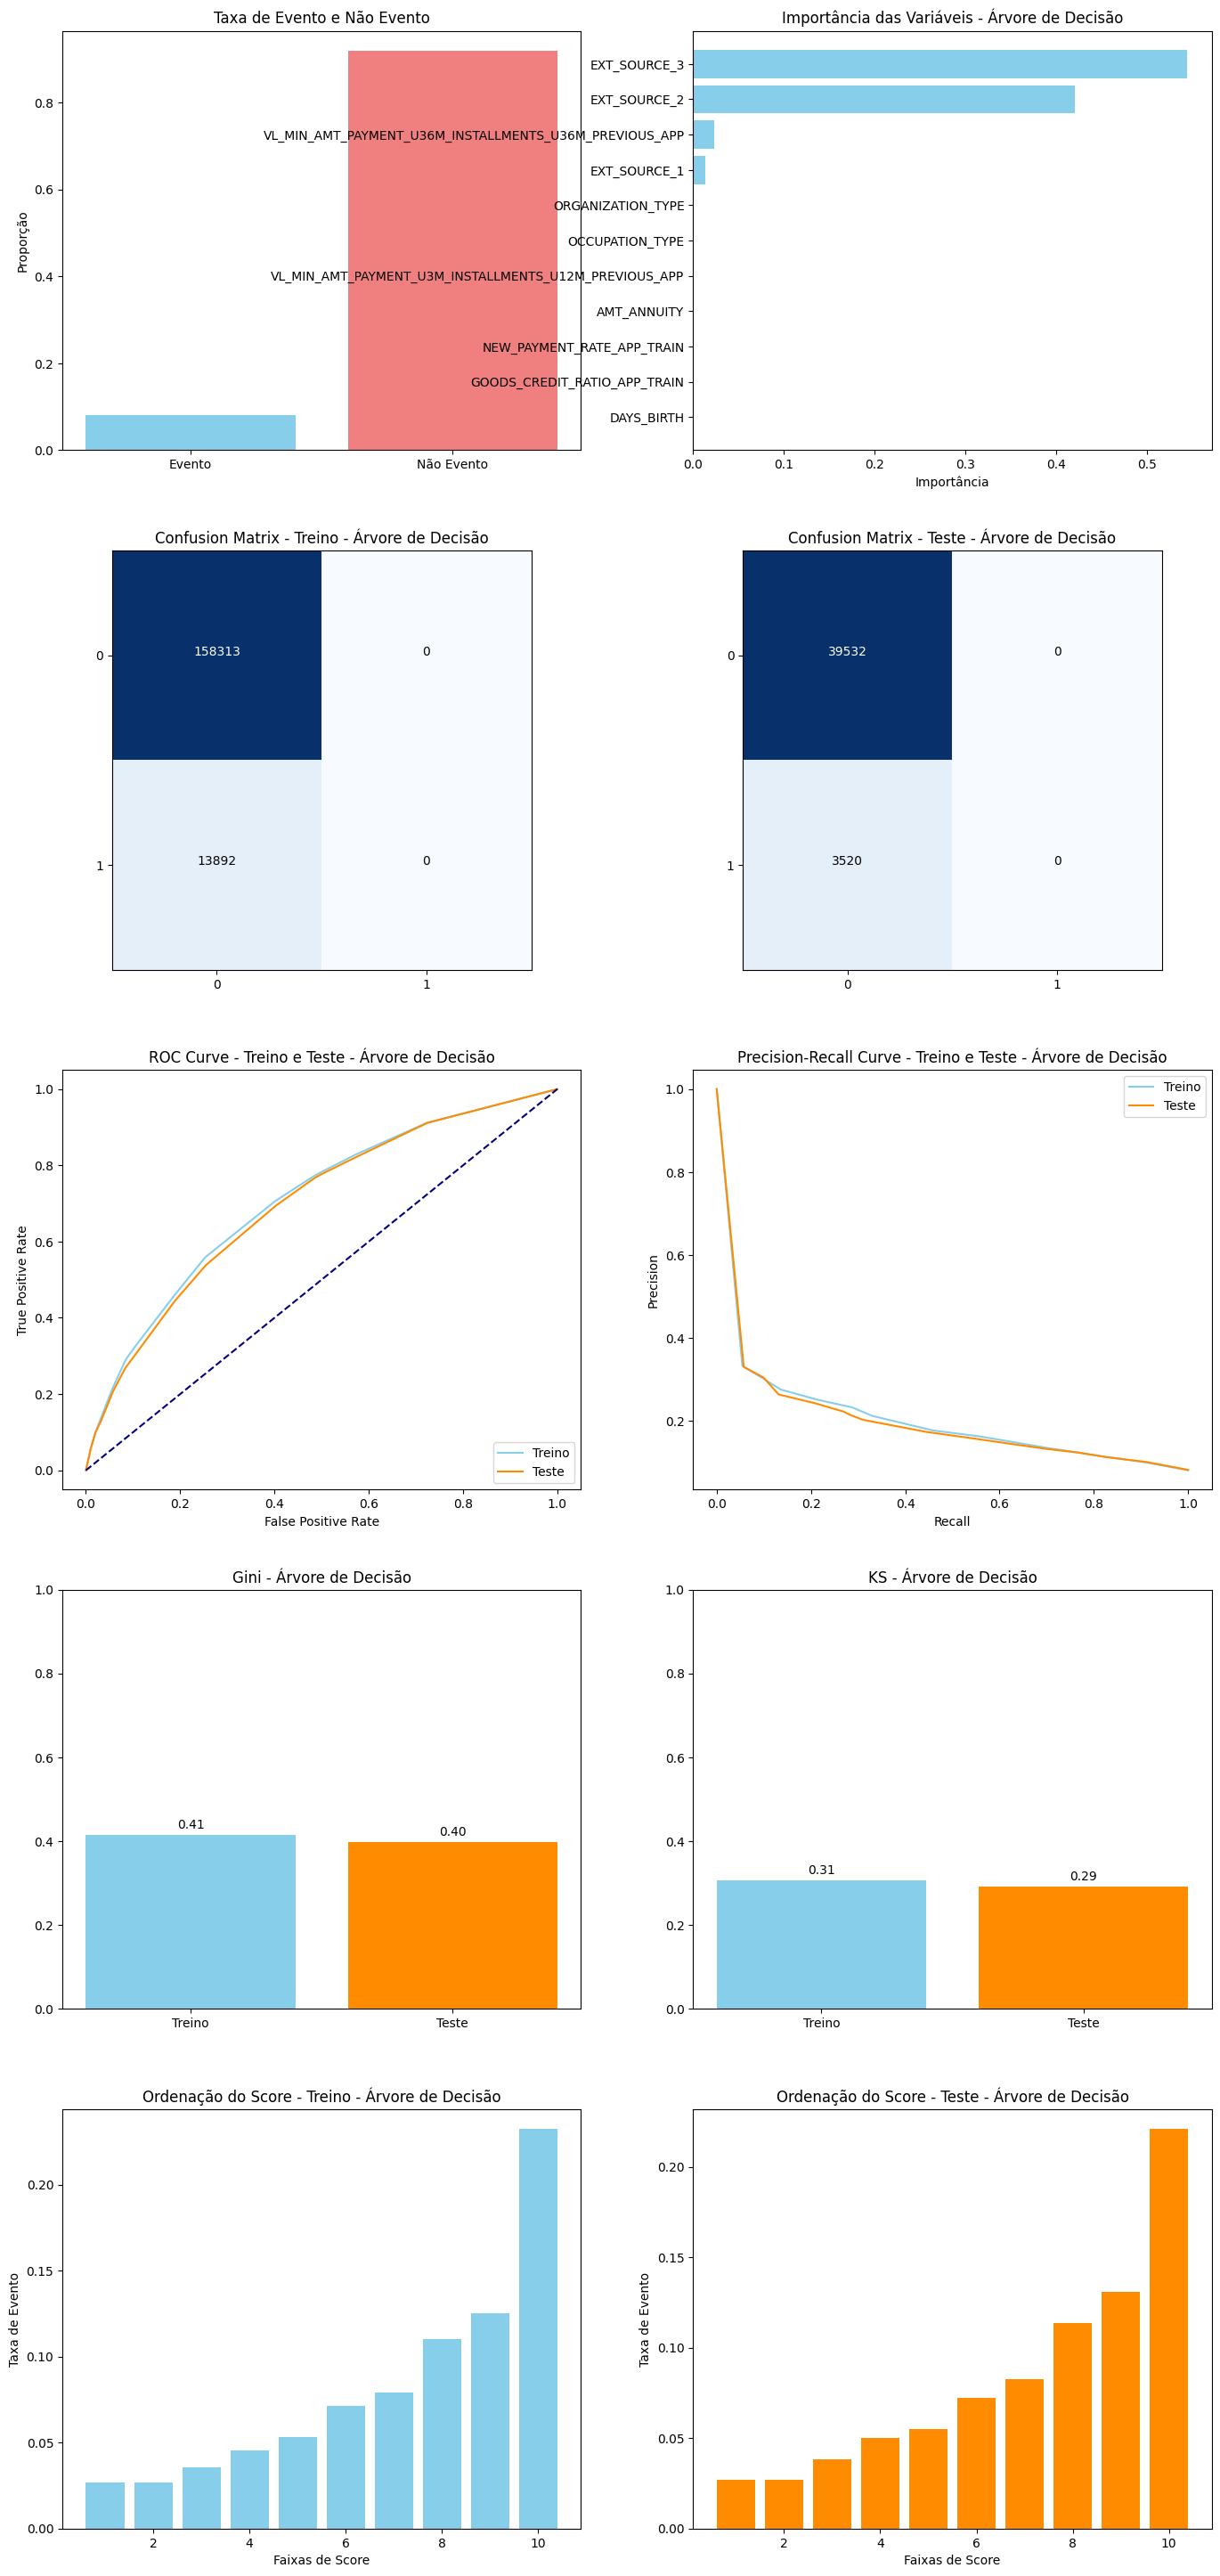

In [ ]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_dt, nm_modelo='Árvore de Decisão')

<br>
<br>
<br>
<br>

### **Treinamento do modelo usando: Random Forest**

In [ ]:
# Definindo o modelo.
model = RandomForestClassifier(random_state=42)

# Definindo os parâmetros para o grid search.
param_grid = {
    'n_estimators': [10, 50],    # Número de árvores na floresta (para modelos como RandomForest).
    'max_depth': [2, 3, 5],    # Profundidade máxima de cada árvore de decisão.
    'min_samples_split': [0.001, 0.01],    # Número mínimo de amostras necessárias para dividir um nó interno.
    'min_samples_leaf': [2, 0.01],    # Número mínimo de amostras necessárias para estar em um nó folha.
    'bootstrap': [True, False],    # Indica se amostras de bootstrap são usadas para construir árvores (para modelos como RandomForest).
    #'max_features': ['auto', 'sqrt', 'log2'],    # Número máximo de features a serem consideradas para dividir um nó.
}

# Calculando a quantidade total de modelos que serão treinados.
num_models = len(list(itertools.product(*param_grid.values()))) * 5     # 5 é o número de folds na validação cruzada (cv).
print(Fore.BLUE + '=' * 150)
print('RESULTADO DO TREINAMENTO DO MODELO'.center(150))
print('')
print(f'Total de Modelos Treinados:  {num_models}')

# Definindo o objeto GridSearchCV
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    verbose=2,
                    scoring='roc_auc',     # 'accuracy' 'precision' 'recall' 'f1'.
                    n_jobs=-1)

# Treinando o modelo com o grid search.
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search.
print('')
print('Melhores Parâmetros: ', grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros.
print('')
print('Melhor AUC: ', grid.best_score_)
print('')
print('=' * 150 + Style.RESET_ALL)

# Utilizando o melhor modelo para fazer previsões.
predictions = grid.best_estimator_.predict(X_test)

best_model_rf = grid.best_estimator_

                                                          RESULTADO DO TREINAMENTO DO MODELO                                                          

Total de Modelos Treinados:  240
Fitting 5 folds for each of 48 candidates, totalling 240 fits

Melhores Parâmetros:  {'bootstrap': True, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 0.01, 'n_estimators': 50}

Melhor AUC:  0.7335706537177614



#### **Avaliando o modelo (Random Forest)**

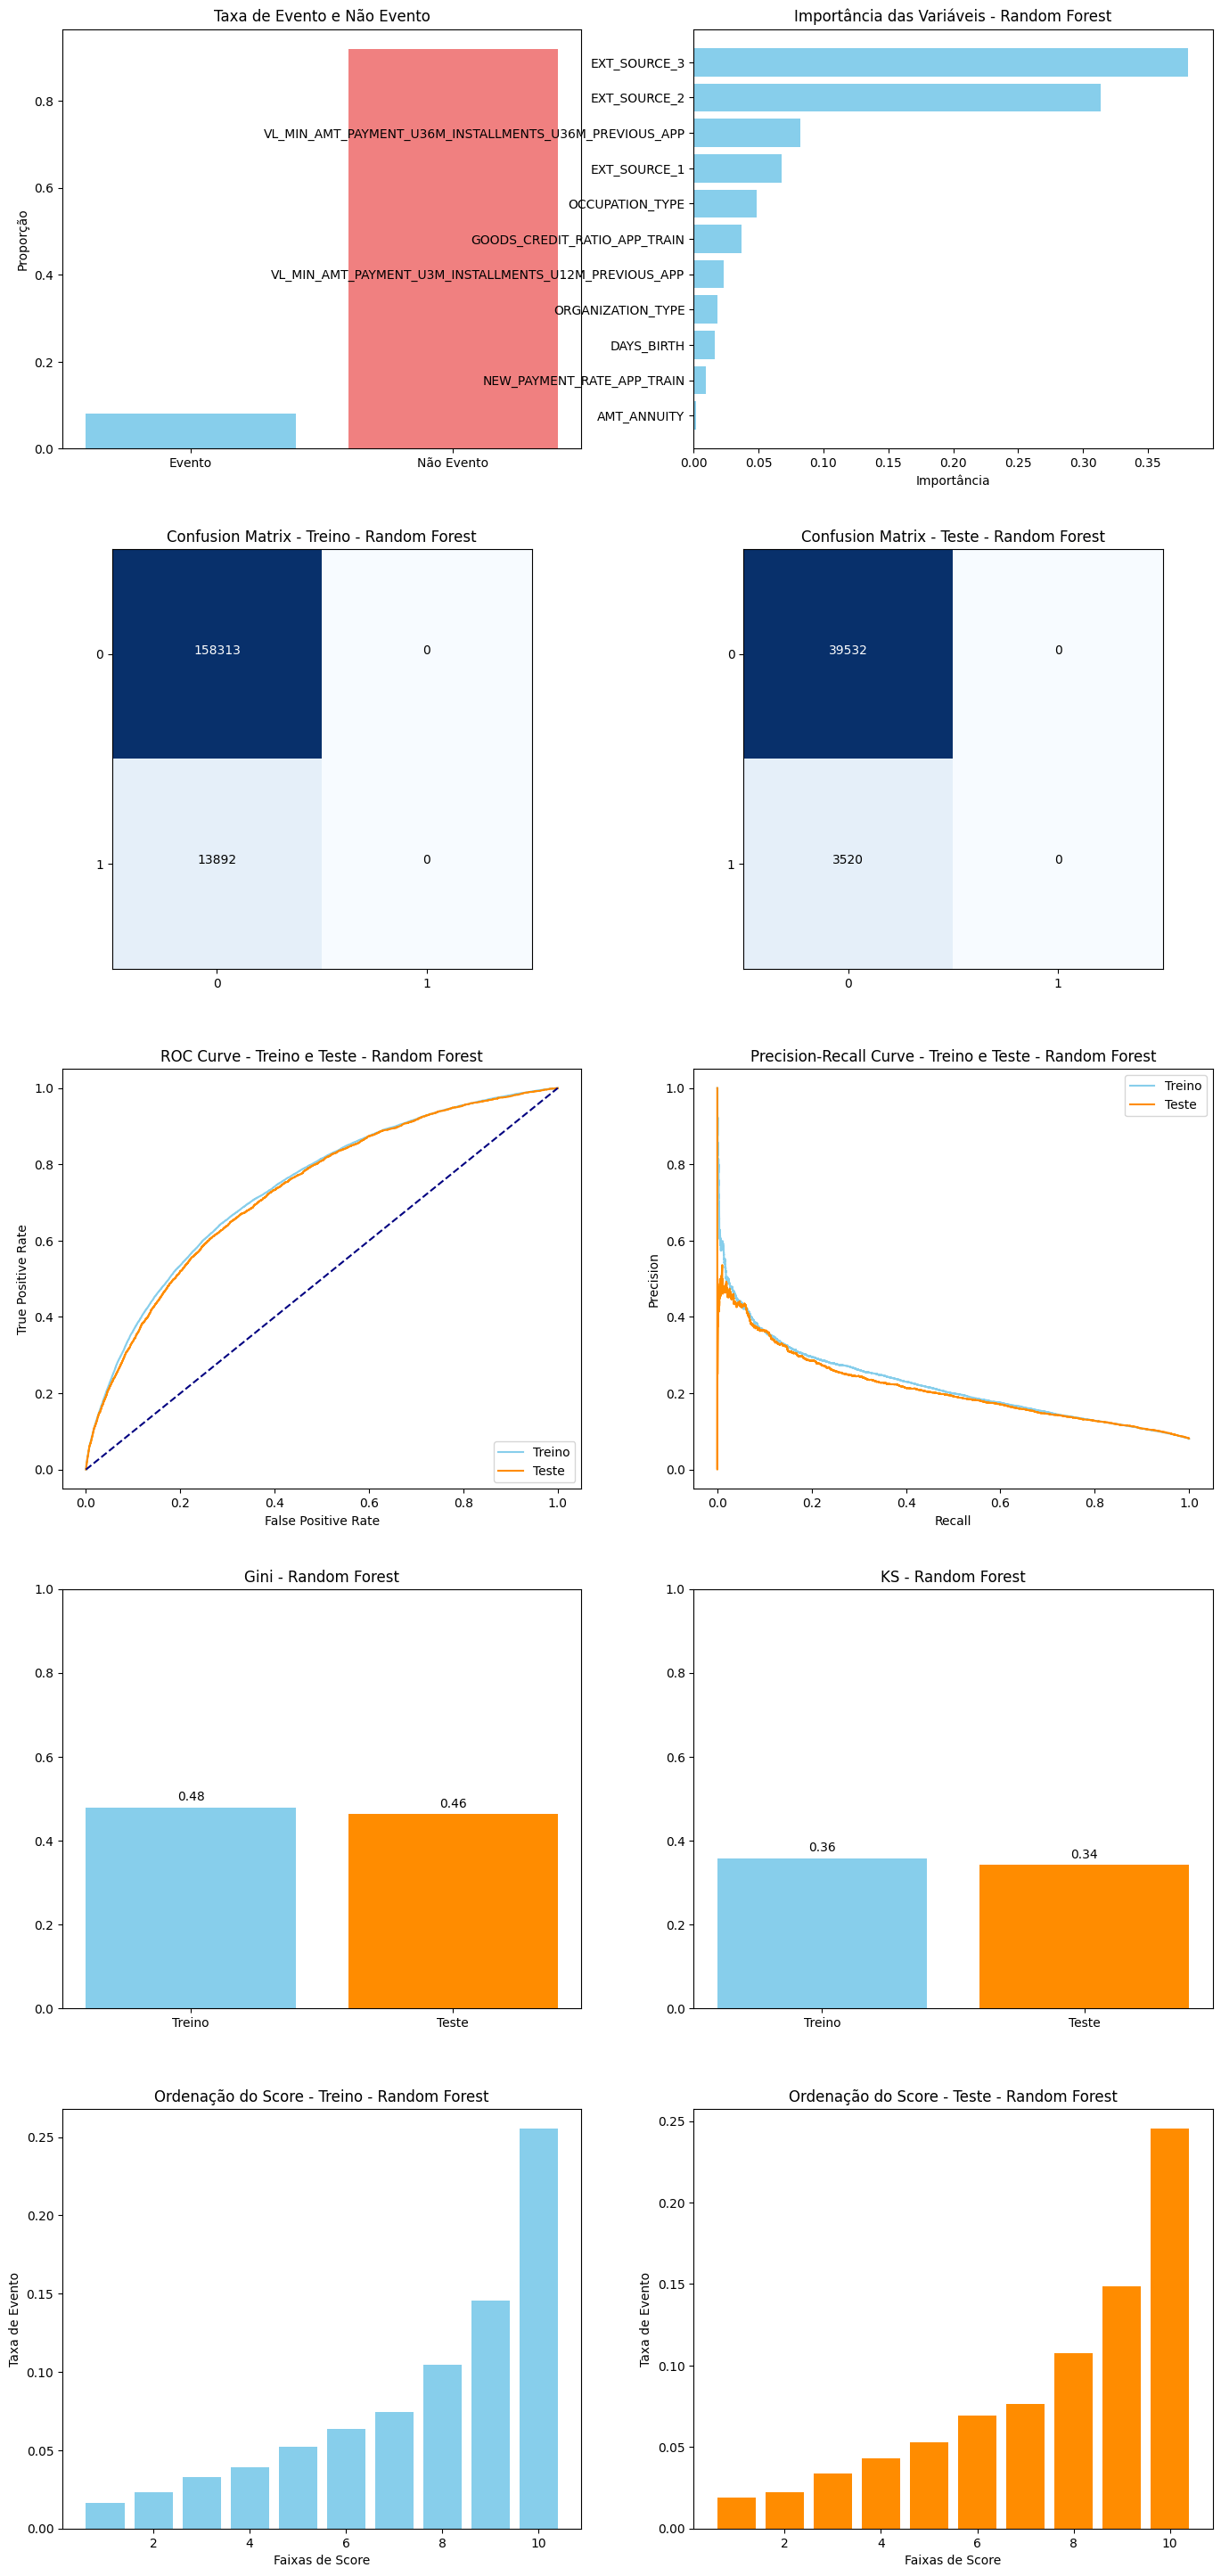

In [ ]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_rf, nm_modelo='Random Forest')

<br>
<br>
<br>
<br>

### **Treinamento do modelo usando: Gradient Boosting**

In [ ]:
# Definindo o modelo.
model = GradientBoostingClassifier(random_state=42)

# Definindo os parâmetros para o grid search.
param_grid = {
    'learning_rate': [0.05, 0.1],     # Taxa de aprendizado que controla a contribuição de cada árvore na sequência de árvores no gradiente boosting.
    'n_estimators': [100],     # Número de árvores de decisão a serem construídas no processo de boosting.
    'max_depth': [5],     # Profundidade máxima de cada árvore de decisão no processo de boosting.
    'min_samples_split': [2, 3],     # Número mínimo de amostras necessárias para dividir um nó interno em uma árvore de decisão.
    'min_samples_leaf': [1, 2],     # Número mínimo de amostras necessárias para estar em um nó folha em uma árvore de decisão.
    'subsample': [0.8],     # Proporção das amostras de treinamento a serem usadas para ajustar cada árvore. Isso é útil para controlar o overfitting.
    #'max_features': ['sqrt', 'log2', None],     # Número máximo de features a serem consideradas ao procurar a melhor divisão em uma árvore de decisão. Pode ser 'sqrt', 'log2' ou None (significando todas as features).
}

# Calculando a quantidade total de modelos que serão treinados.
num_models = len(list(itertools.product(*param_grid.values()))) * 5     # 5 é o número de folds na validação cruzada (cv).
print(Fore.BLUE + '=' * 150)
print('RESULTADO DO TREINAMENTO DO MODELO'.center(150))
print('')
print(f'Total de Modelos Treinados:  {num_models}')

# Definindo o objeto GridSearchCV.
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    verbose=2,
                    scoring='roc_auc',     # 'accuracy' 'precision' 'recall' 'f1'.
                    n_jobs=-1)

# Treinando o modelo com o grid search.
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search.
print('')
print('Melhores Parâmetros: ', grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros.
print('')
print('Melhor AUC: ', grid.best_score_)
print('')
print('=' * 150 + Style.RESET_ALL)

# Utilizando o melhor modelo para fazer previsões.
predictions = grid.best_estimator_.predict(X_test)

best_model_gbm = grid.best_estimator_

                                                          RESULTADO DO TREINAMENTO DO MODELO                                                          

Total de Modelos Treinados:  40
Fitting 5 folds for each of 8 candidates, totalling 40 fits

Melhores Parâmetros:  {'learning_rate': 0.1, 'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100, 'subsample': 0.8}

Melhor AUC:  0.7565659320704724



#### **Avaliando o modelo (Gradient Boosting)**

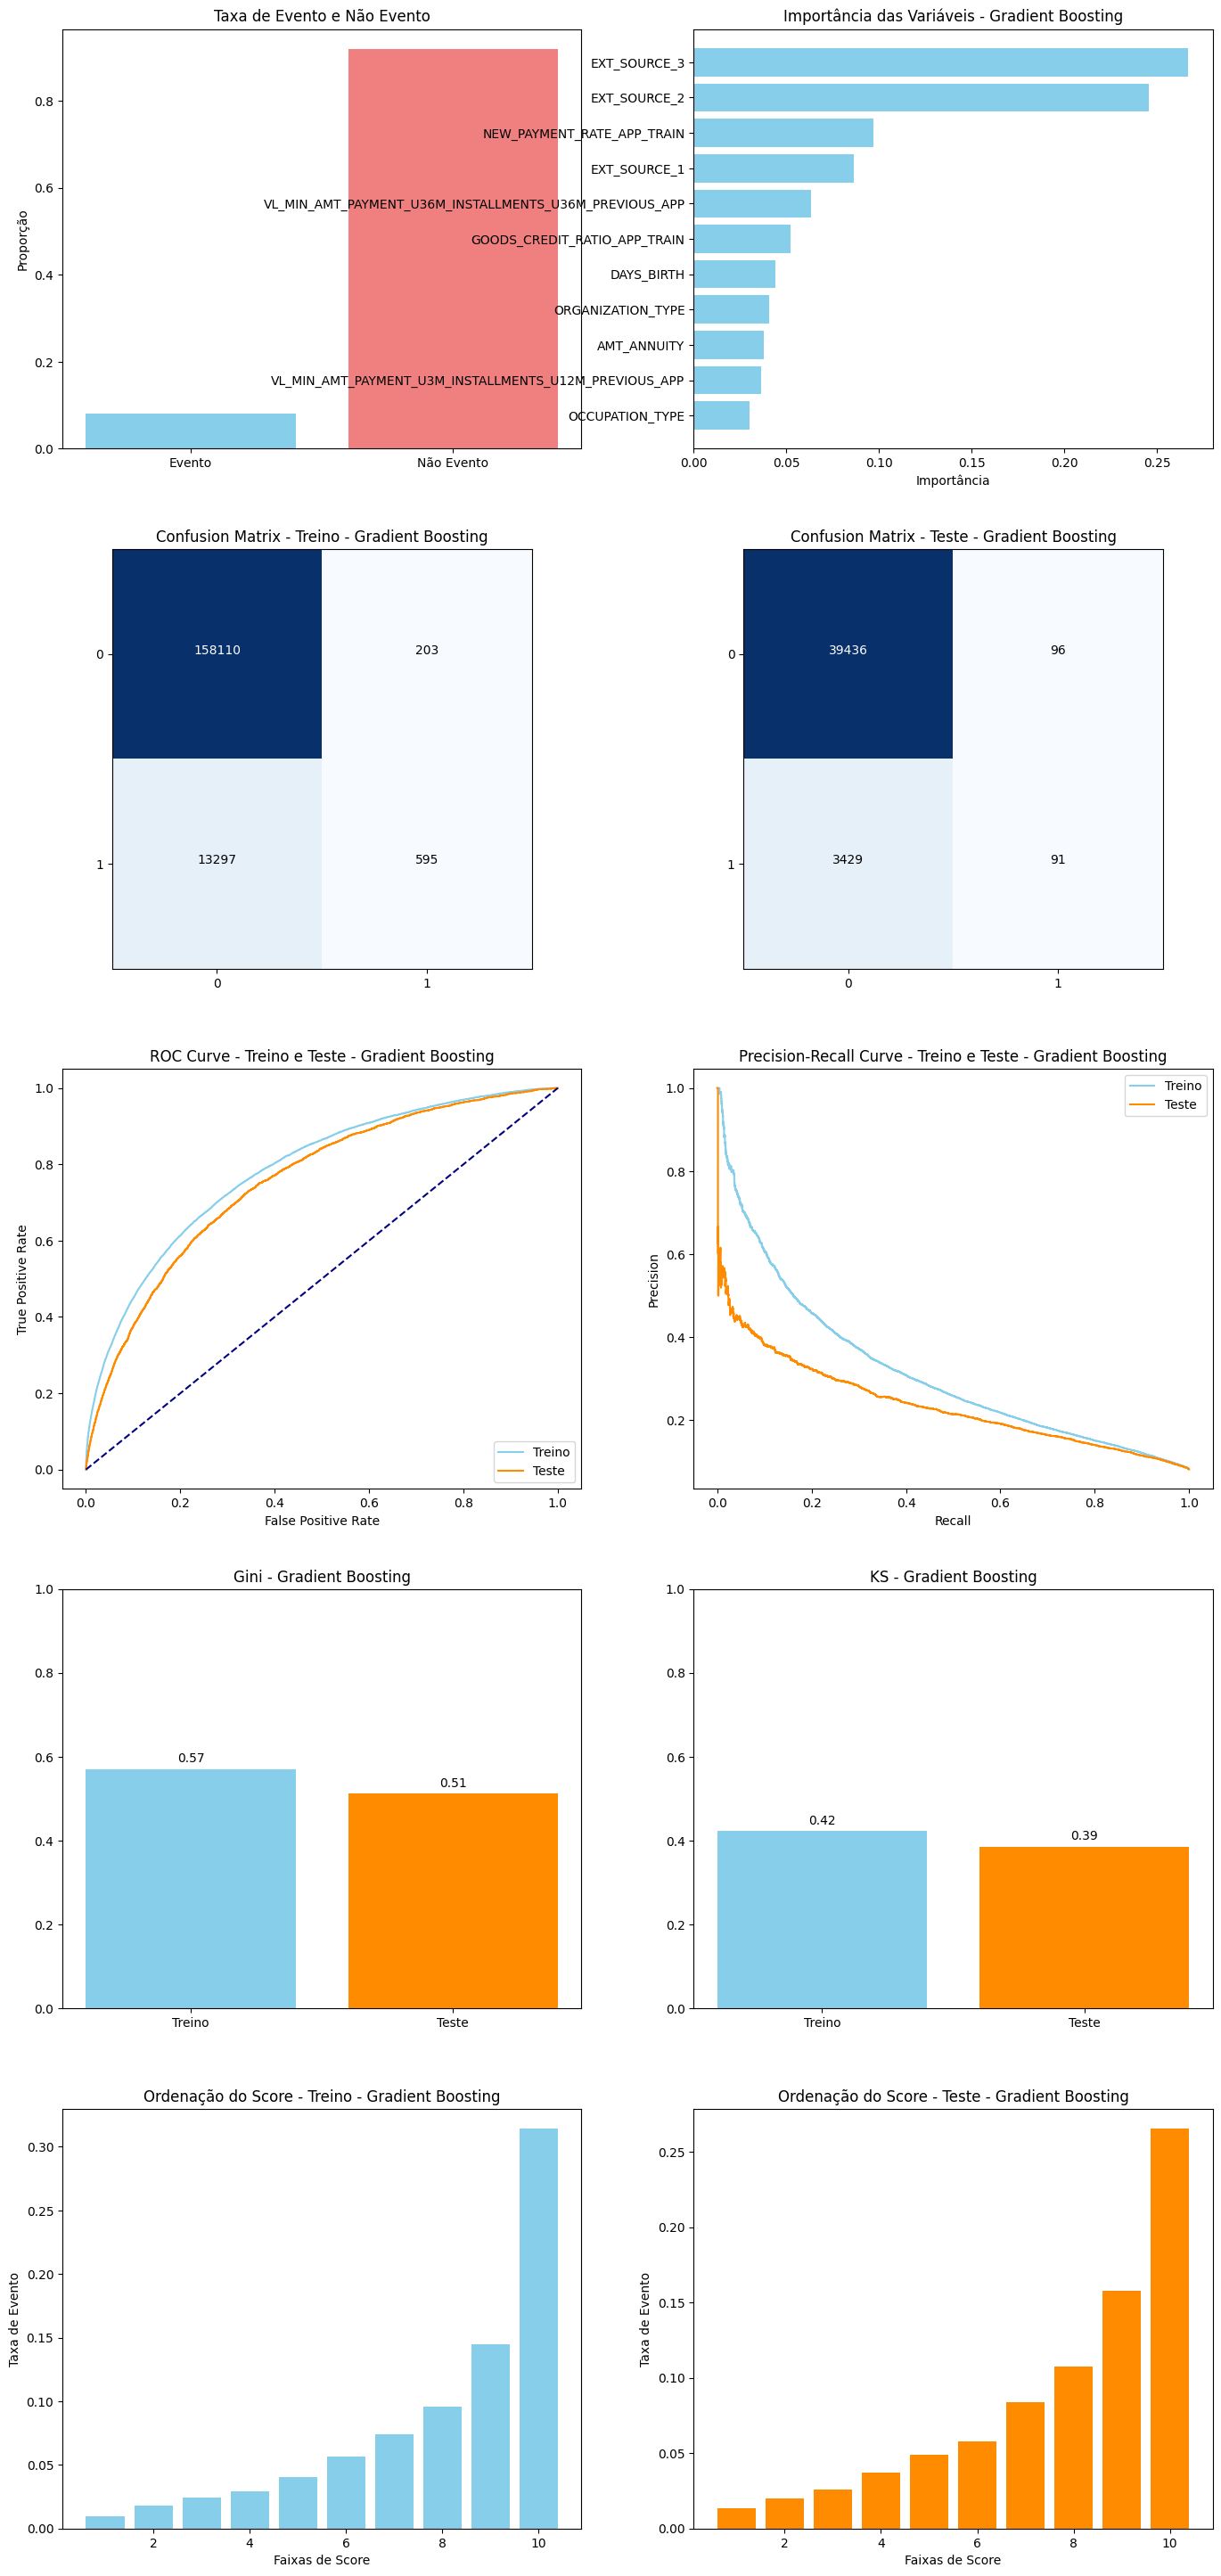

In [ ]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_gbm, nm_modelo='Gradient Boosting')

<br>
<br>
<br>
<br>

### **Treinamento do modelo usando: LightGBM (Light Gradient Boosting Machine)**

In [ ]:
# Definindo o modelo.
model = lgb.LGBMClassifier(random_state=42, verbosity=-1)

# Definindo os parâmetros para o grid search.
param_grid = {
    'max_depth': [3, 5],     # Profundidade máxima de cada árvore de decisão no modelo LightGBM.
    'num_leaves': [15, 30],     # Número máximo de folhas em uma árvore de decisão no modelo LightGBM.
    'reg_alpha': [0.05, 0.1],     # Parâmetro de regularização L1 (Lasso) que controla a penalidade adicionada à soma dos valores absolutos dos pesos das folhas.
    'min_data_in_leaf': [3, 5],     # Número mínimo de amostras necessárias para estar em um nó folha em uma árvore de decisão no modelo LightGBM.
    'lambda_l1': [0.05, 0.1],     # Parâmetro de regularização L1 (Lasso) adicional, semelhante ao reg_alpha, mas para o termo de regularização L1 na função de perda.
    'lambda_l2': [0.05, 0.1],     # Parâmetro de regularização L2 (Ridge) adicional, semelhante ao reg_alpha, mas para o termo de regularização L2 na função de perda.
}

# Calculando a quantidade total de modelos que serão treinados.
num_models = len(list(itertools.product(*param_grid.values()))) * 5     # 5 é o número de folds na validação cruzada (cv).
print(Fore.BLUE + '=' * 150)
print('RESULTADO DO TREINAMENTO DO MODELO'.center(150))
print('')
print(f'Total de Modelos Treinados:  {num_models}')

# Definindo o objeto GridSearchCV.
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    verbose=2,
                    scoring='roc_auc',     # 'accuracy' 'precision' 'recall' 'f1'.
                    n_jobs=-1)

# Treinando o modelo com o grid search.
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search.
print('')
print('Melhores Parâmetros: ', grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros.
print('')
print('Melhor AUC: ', grid.best_score_)
print('')
print('=' * 150 + Style.RESET_ALL)

# Utilizando o melhor modelo para fazer previsões.
predictions = grid.best_estimator_.predict(X_test)

best_model_lightgbm = grid.best_estimator_

                                                          RESULTADO DO TREINAMENTO DO MODELO                                                          

Total de Modelos Treinados:  320
Fitting 5 folds for each of 64 candidates, totalling 320 fits

Melhores Parâmetros:  {'lambda_l1': 0.1, 'lambda_l2': 0.1, 'max_depth': 5, 'min_data_in_leaf': 3, 'num_leaves': 30, 'reg_alpha': 0.05}

Melhor AUC:  0.7579478158639574



#### **Avaliando o modelo (LightGBM)**

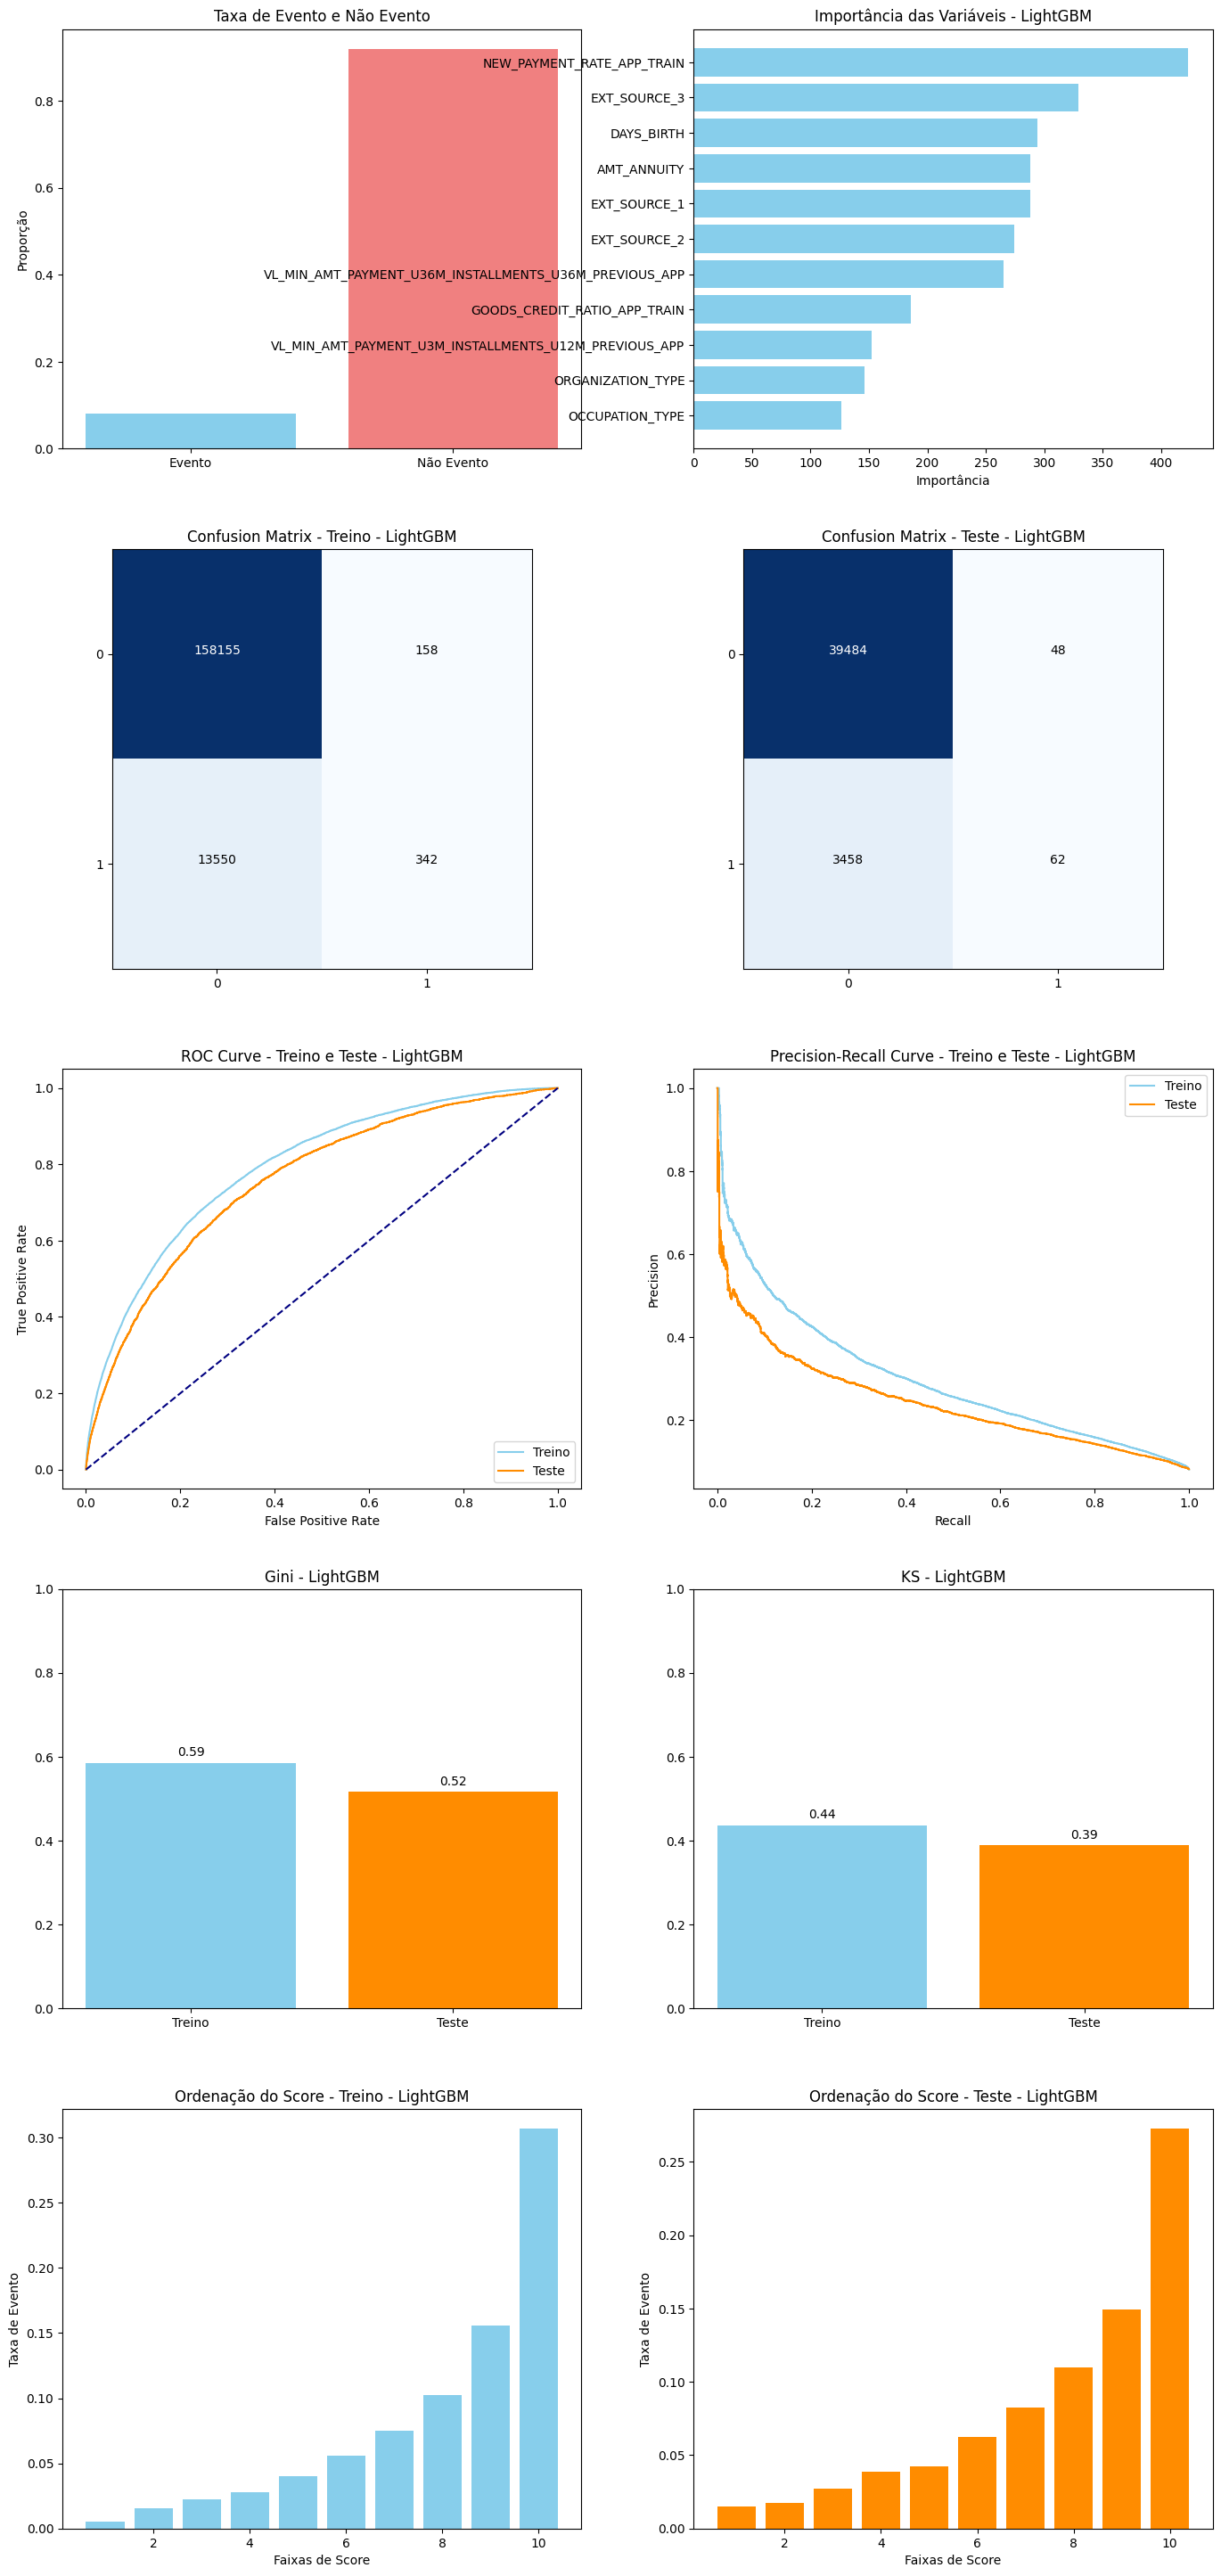

In [ ]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_lightgbm, nm_modelo='LightGBM')

<br>
<br>
<br>
<br>

### **Treinamento do modelo usando: XGBoost (eXtreme Gradient Boosting)**

In [ ]:
# Definindo o modelo.
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
# use_label_encoder=False: Este parâmetro controla se o classificador deve ou não usar um codificador de rótulo para converter os rótulos de classe em valores numéricos. Quando definido como False, o classificador assume que os rótulos de classe já estão codificados como valores numéricos. Isso é útil quando você já tem seus rótulos codificados e deseja evitar a conversão automática.
# eval_metric='mlogloss': Este parâmetro especifica a métrica de avaliação a ser usada durante o treinamento do modelo. No caso deste exemplo, 'mlogloss' refere-se à perda logarítmica multinomial, que é uma métrica comumente usada para problemas de classificação multiclasse. A perda logarítmica (também conhecida como entropia cruzada) é uma medida da discrepância entre as distribuições de probabilidade previstas pelo modelo e as distribuições reais dos rótulos de classe. A minimização da perda logarítmica é um objetivo comum durante o treinamento de modelos de classificação.

# Definindo os parâmetros para o grid search.
param_grid = {
    'learning_rate': [0.1, 0.15],     # Taxa de aprendizado que controla a contribuição de cada árvore na sequência de árvores no modelo XGBoost.
    'max_depth': [4, 5],     # Profundidade máxima de cada árvore de decisão no modelo XGBoost.
    'min_child_weight': [1],     # Peso mínimo necessário de uma criança (nó) para dividir um nó.
    'subsample': [0.8, 0.9],     # Proporção de observações a serem amostradas aleatoriamente para construir cada árvore.
    'colsample_bytree': [0.8, 0.9],     # Proporção de features a serem amostradas aleatoriamente para construir cada árvore.
    'n_estimators': [200, 250],     # Número de árvores (estimadores) a serem construídas no modelo XGBoost.
}

# Calculando a quantidade total de modelos que serão treinados.
num_models = len(list(itertools.product(*param_grid.values()))) * 5     # 5 é o número de folds na validação cruzada (cv).
print(Fore.BLUE + '=' * 150)
print('RESULTADO DO TREINAMENTO DO MODELO'.center(150))
print('')
print(f'Total de Modelos Treinados:  {num_models}')

# Definindo o objeto GridSearchCV.
grid = GridSearchCV(model,
                    param_grid,
                    cv=5,
                    verbose=2,
                    scoring='roc_auc',     # 'accuracy' 'precision' 'recall' 'f1'.
                    n_jobs=-1)

# Treinando o modelo com o grid search.
grid.fit(X_train, y_train)

# Exibindo os melhores parâmetros encontrados pelo grid search.
print('')
print('Melhores Parâmetros: ', grid.best_params_)

# Exibindo a melhor pontuação (score) atingida pelo modelo com os melhores parâmetros.
print('')
print('Melhor AUC: ', grid.best_score_)
print('')
print('=' * 150 + Style.RESET_ALL)

# Utilizando o melhor modelo para fazer previsões.
predictions = grid.best_estimator_.predict(X_test)

best_model_xgbm = grid.best_estimator_

                                                          RESULTADO DO TREINAMENTO DO MODELO                                                          

Total de Modelos Treinados:  160
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Melhores Parâmetros:  {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 250, 'subsample': 0.9}

Melhor AUC:  0.76036526309076



#### **Avaliando o modelo (XGBoost)**

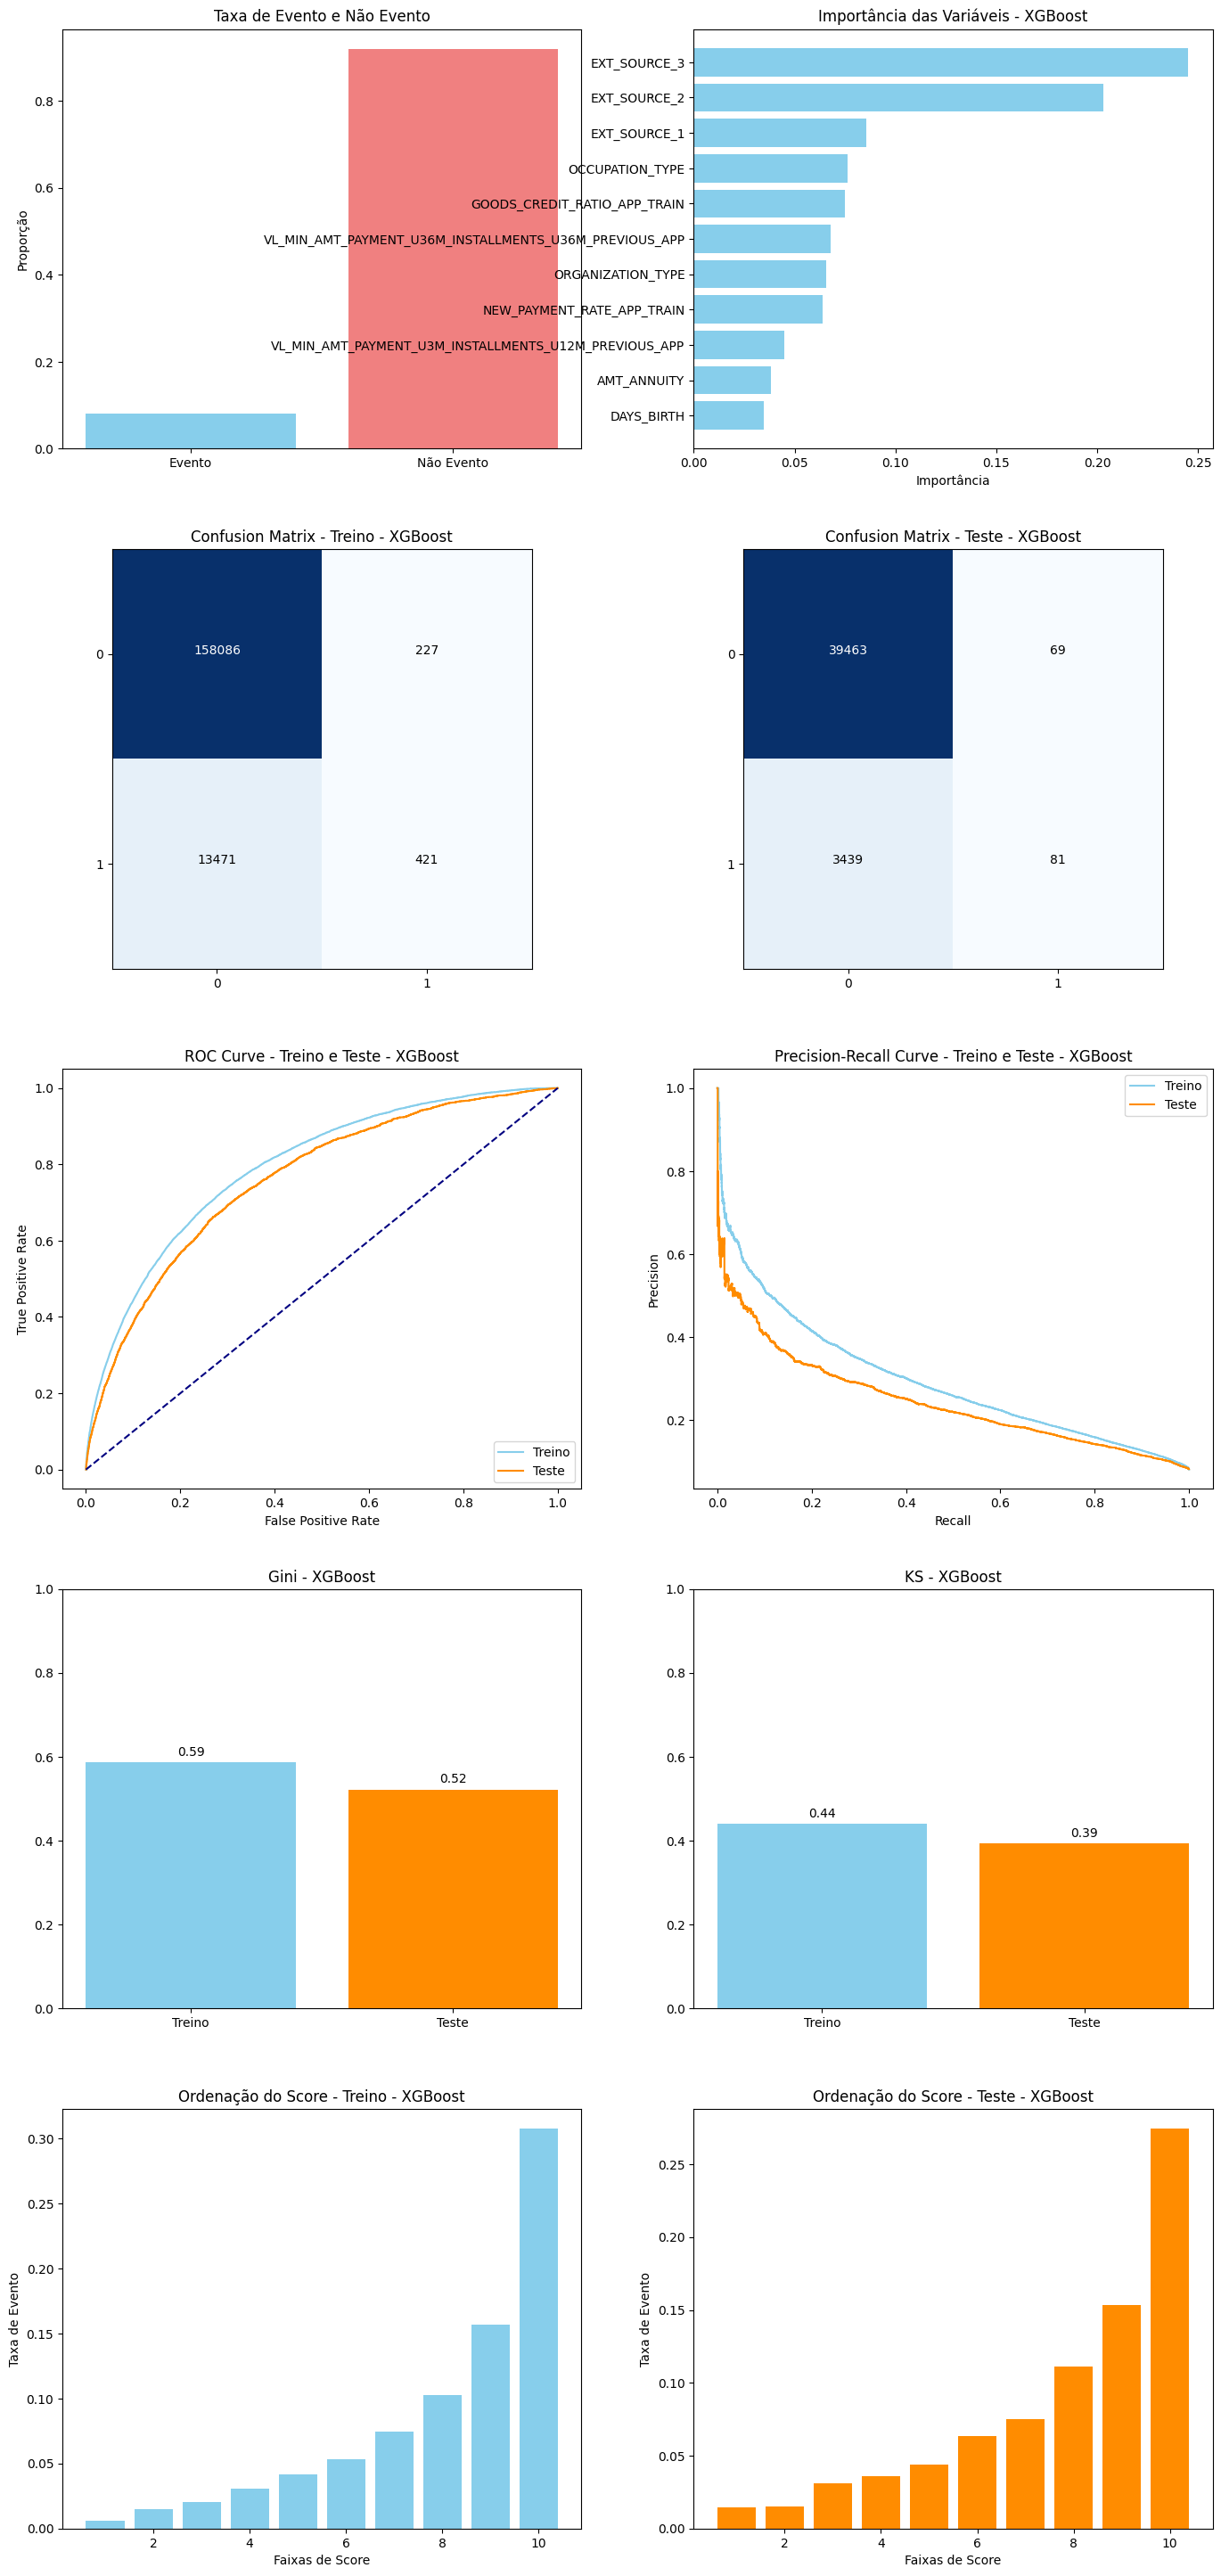

In [ ]:
avaliar_modelo(X_train, y_train, X_test, y_test, best_model_xgbm, nm_modelo='XGBoost')

<br>
<br>
<br>
<br>

## **Comparação das métricas dos modelos treinados (base de teste)**

In [ ]:
# Criando uma lista com os modelos treinados.
models = {'Decision Tree': best_model_dt,
          'Random Forest': best_model_rf,
          'Gradient Boosting': best_model_gbm,
          'LightGBM': best_model_lightgbm,
          'XGBoost': best_model_xgbm,
         }

# Chamando a função com os datasets de treino e teste e os modelos carregados.
metrics_df = evaluate_models(X_train, y_train, X_test, y_test, models)

metrics_df

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,Model,AUC-ROC,Accuracy,Precision,Recall,F1 Score,Gini,KS,Training_Time(s)
4,XGBoost,0.760741,0.918517,0.540000,0.023011,0.044142,0.521482,0.392767,1.611461
3,LightGBM,0.758315,0.918564,0.563636,0.017614,0.034160,0.516630,0.389175,2.285922
2,Gradient Boosting,0.756326,0.918122,0.486631,0.025852,0.049096,0.512651,0.385818,0.875611
1,Random Forest,0.731598,0.918238,0.000000,0.000000,0.000000,0.463197,0.342763,1.240586
0,Decision Tree,0.698579,0.918238,0.000000,0.000000,0.000000,0.397157,0.291501,0.125705


<br>

**Modelo escolhido com base nas métricas AUC-ROC, Gini e KS:** XGBoost

In [ ]:
# Definindo o modelo escolhido e o nome do modelo.
model = best_model_xgbm
name_model = 'XGBoost'

In [ ]:
# Salvando o modelo escolhido em um arquivo .pkl (artefato).
with open(dir_pkl + '/model_gridsearch_XGBoost.pkl', 'wb') as file:
  pickle.dump(model, file)

<br>
<br>
<br>
<br>

## **Métricas do modelo escolhido**

In [ ]:
# Chamando a função para métricas.
df_metrics = calculate_metrics_01(name_model, model, X_train, y_train, X_test, y_test)
df_metrics

,Algoritmo,Conjunto,Acuracia,Precision,Recall,AUC_ROC,GINI,KS
0,XGBoost,Treino,0.920455,0.649691,0.030305,0.793232,0.586464,0.439888
1,XGBoost,Teste,0.918517,0.540000,0.023011,0.760741,0.521482,0.392767


In [ ]:
# Criando tabela com as taxas de evento para cada faixa, para o conjunto de treino.
y_train.index = X_train.index
bins = 10
tab_train = pd.concat([X_train, y_train], axis=1).copy()
tab_train['score'] = model.predict_proba(tab_train.drop(columns=['TARGET']))[:,0]
tab_train['decile'] = pd.qcut(tab_train['score'], bins, labels=False)

table_train = tab_train.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='TARGET', aggfunc='mean'),
    volume=pd.NamedAgg(column='TARGET', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()/tab_train[tab_train.TARGET == 1].shape[0])
).reset_index()
table_train['min_score'] = 1000 * table_train['min_score']
table_train['max_score'] = 1000 * table_train['max_score']
table_train = table_train[['decile','event_rate','perc_total_bads']]
table_train.columns = ['decile','event_rate_train','perc_total_bads_train']


# Criando tabela com as taxas de evento para cada faixa, para o conjunto de teste.
y_test.index = X_test.index
bins = 10
tab_test = pd.concat([X_test, y_test], axis=1).copy()
tab_test['score'] = model.predict_proba(tab_test.drop(columns=['TARGET']))[:,0]
tab_test['decile'] = pd.qcut(tab_test['score'], bins, labels=False)

table_test = tab_test.groupby('decile').agg(
    min_score=pd.NamedAgg(column='score', aggfunc='min'),
    max_score=pd.NamedAgg(column='score', aggfunc='max'),
    event_rate=pd.NamedAgg(column='TARGET', aggfunc='mean'),
    volume=pd.NamedAgg(column='TARGET', aggfunc='size'),
    qt_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()),
    perc_total_bads=pd.NamedAgg(column='TARGET', aggfunc=lambda x: (x == 1).sum()/tab_test[tab_test.TARGET == 1].shape[0])
).reset_index()
table_test['min_score'] = 1000 * table_test['min_score']
table_test['max_score'] = 1000 * table_test['max_score']
table_test = table_test[['decile','event_rate','perc_total_bads']]
table_test.columns = ['decile','event_rate_test','perc_total_bads_test']


# Unificando as tabelas.
summary = pd.merge(table_train, table_test, on='decile', how='inner')
summary

,decile,event_rate_train,perc_total_bads_train,event_rate_test,perc_total_bads_test
0,0,0.307241,0.380867,0.274268,0.335511
1,1,0.156330,0.193781,0.153310,0.187500
2,2,0.102491,0.127052,0.111034,0.135795
3,3,0.074564,0.092427,0.075494,0.092330
4,4,0.053365,0.066153,0.063415,0.077557
5,5,0.041289,0.051181,0.043206,0.052841
6,6,0.030256,0.037504,0.036469,0.044602
7,7,0.020208,0.025050,0.030662,0.037500
8,8,0.015157,0.018788,0.015099,0.018466
9,9,0.005807,0.007198,0.014631,0.017898


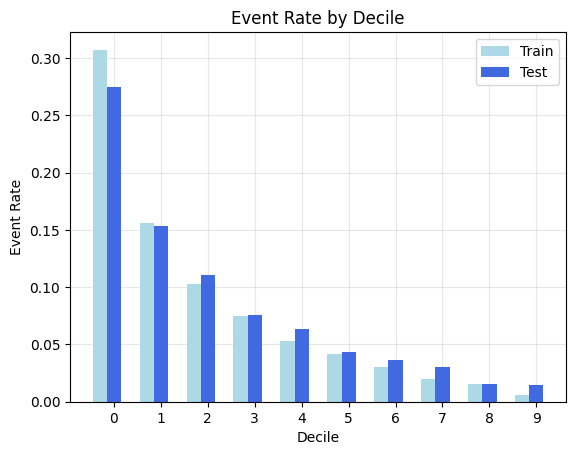

In [ ]:
# Plotando o gráfico de barras para Event Rate por Decil
barWidth = 0.3
r1 = np.arange(len(summary))
r2 = [x + barWidth for x in r1]

plt.bar(r1, summary['event_rate_train'], color='lightblue', width=barWidth, label='Train')
plt.bar(r2, summary['event_rate_test'], color='royalblue', width=barWidth, label='Test')

plt.xlabel('Decile')
plt.ylabel('Event Rate')
plt.title('Event Rate by Decile')
plt.xticks([r + barWidth for r in range(len(summary))], summary['decile'])
plt.grid(axis='y', linestyle='-', alpha=0.3)
plt.grid(axis='x', linestyle='-', alpha=0.3)
plt.gca().set_axisbelow(True)
plt.legend()
plt.show()

<br>
<br>
<br>
<br>

## **Análise das faixas de score e apetite de risco**

In [ ]:
# Fazendo uma cópia dos DataFrames.
X_train_01 = X_train.copy()
y_train_01 = y_train.copy()

X_test_01 = X_test.copy()
y_test_01 = y_test.copy()

# Prevendo a probabilidade de evento.
X_train_01['Score_1'] = model.predict_proba(X_train)[:, 1].round(4)
X_test_01['Score_1'] = model.predict_proba(X_test)[:, 1].round(4)

# Calculando a probabilidade de não evento.
X_train_01['Score_0'] = 1 - X_train_01['Score_1']
X_test_01['Score_0'] = 1 - X_test_01['Score_1']

<br>

### **Treino**

**Apetite de risco de 8,0% (atual da carteira)**

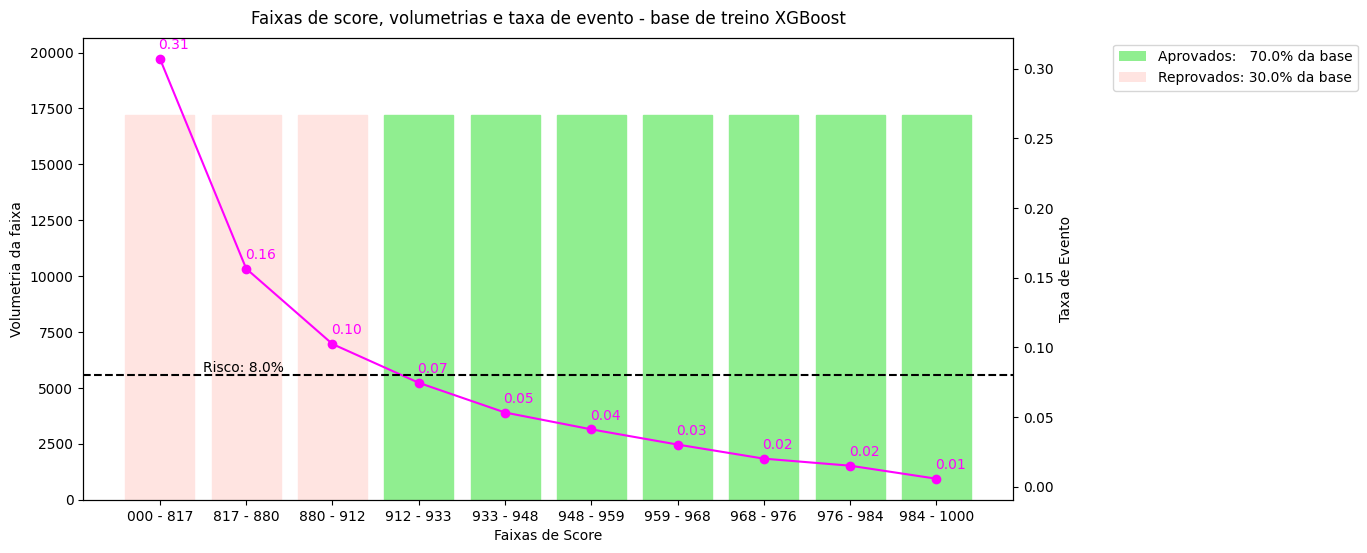

In [ ]:
# Análise da carteira dos dados de treino - Apetite de risco de 8,0%.
faixas_treino_8 = carteira_treino_rl(model, name_model, risk = 0.08, X_train = X_train_01, y_train = y_train_01, prob_train = X_train_01['Score_0'])

**Apetite de risco de 5,0% (conservador)**

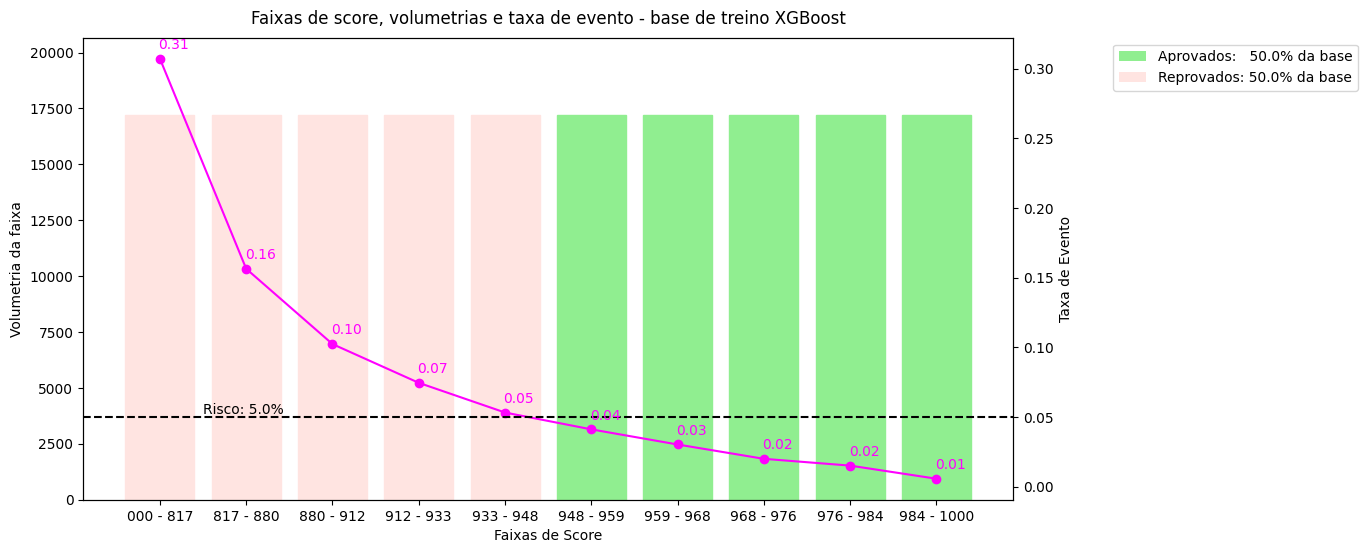

In [ ]:
# Análise da carteira dos dados de treino - Apetite de risco de 5,0%.
faixas_treino_5 = carteira_treino_rl(model, name_model, risk = 0.05, X_train = X_train_01, y_train = y_train_01, prob_train = X_train_01['Score_0'])

**Apetite de risco de 12,0% (ousado)**

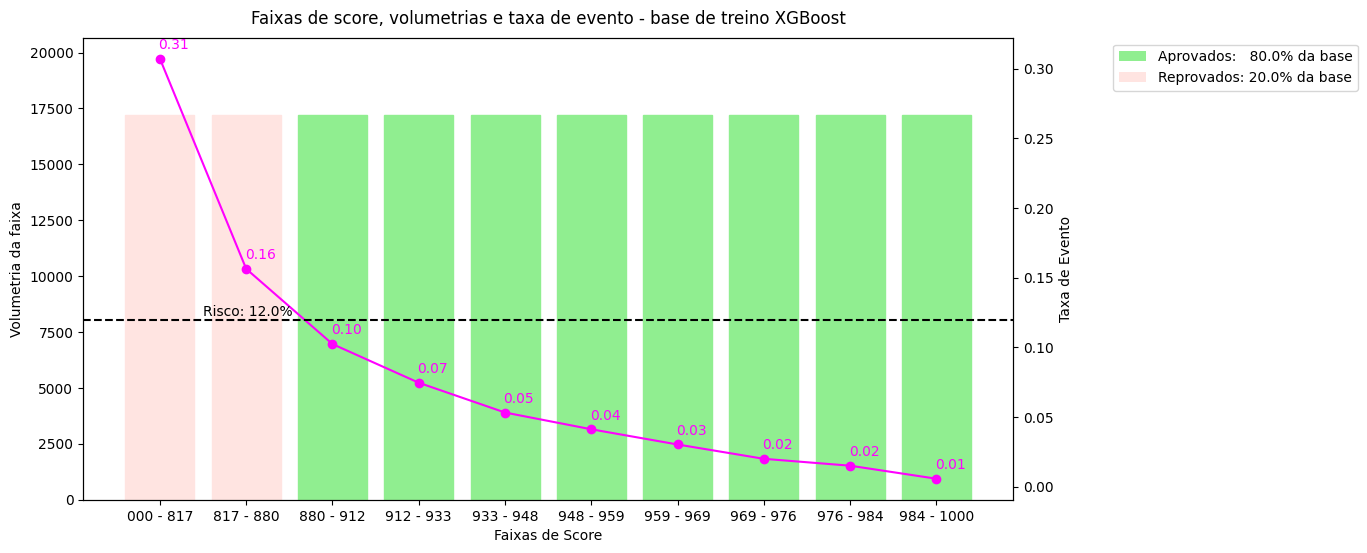

In [ ]:
# Análise da carteira dos dados de treino - Apetite de risco de 12,0%.
faixas_treino_12 = carteira_treino_rl(model, name_model, risk = 0.12, X_train = X_train_01, y_train = y_train_01, prob_train = X_train_01['Score_0'])

<br>

### **Teste**

**Apetite de risco de 8,0% (atual da carteira)**

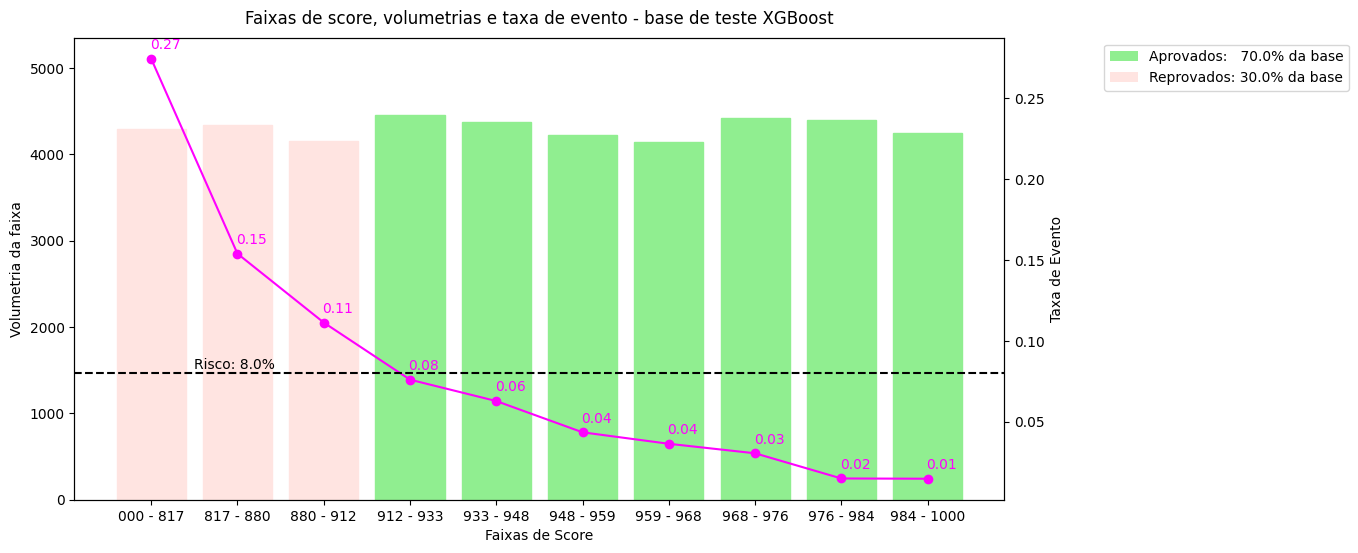

In [ ]:
# Análise da carteira dos dados de teste - Apetite de risco de 8,0%.
faixas_teste_8 = carteira_teste_rl(faixas = faixas_treino_8, model = model, name_model = name_model, risk=0.08, X_test = X_test_01, y_test = y_test_01, prob_test = X_test_01['Score_0'])

**Apetite de risco de 5,0% (conservador)**

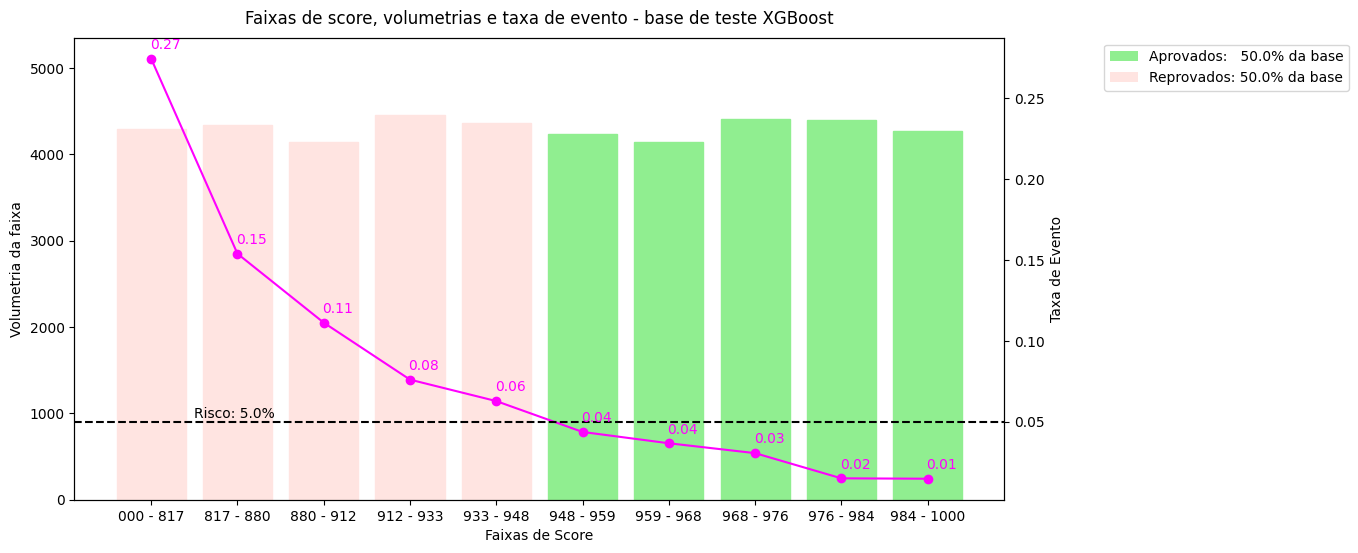

In [ ]:
# Análise da carteira dos dados de teste - Apetite de risco de 8,0%.
faixas_teste_5 = carteira_teste_rl(faixas = faixas_treino_5, model = model, name_model = name_model, risk=0.05, X_test = X_test_01, y_test = y_test_01, prob_test = X_test_01['Score_0'])

**Apetite de risco de 12,0% (ousado)**

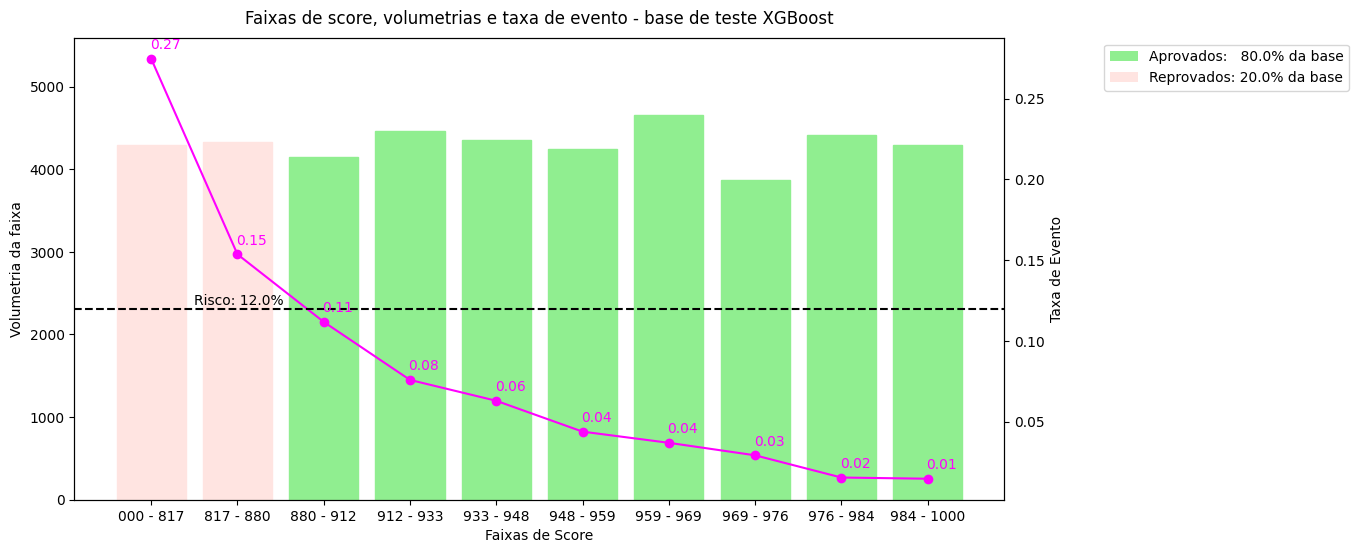

In [ ]:
# Análise da carteira dos dados de teste - Apetite de risco de 12,0%.
faixas_teste_12 = carteira_teste_rl(faixas = faixas_treino_12, model = model, name_model = name_model, risk=0.12, X_test = X_test_01, y_test = y_test_01, prob_test = X_test_01['Score_0'])